In [1]:
#inventory management + v5

In [2]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory
#from gurobipy import GRB

In [3]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')


CAP_reliability = [-2,-1,0] # -1 if 1 sd below mean, -2 if 2 sd below mean
DEMAND_reliability = [0,1,2] #1 if 1 sd above mean, 2 if 2 sd above mean
budget_levels = range(1,12+1)

level_amount_incrememented = 10000
warehouse_cap_level = 3 #time intervals of supply that can be stored

trade_off_dict = {}

In [4]:
#define sets
K = 1
I = 4
T = 10

In [5]:
def initialize_model(CAP_reliability, DEMAND_reliability, 
                     budget_level):
    
    global warehouse_cap_level
    global level_amount_incrememented
    global K
    global I
    global T
    
    #define parameters
    #rank
    r_k_dict = {
        1 : 1
    }

    #quality (supplier 4 has the highest quality)
    q_k_i_dict = {
        tuple([1,1]) : 3,
        tuple([1,2]): 2,
        tuple([1,3]): 2,
        tuple([1,4]): 2
    }

    #starting inventory
    z_k_i_init_dict = {
        tuple([1,1]) : 11918/4,
        tuple([1,2]) : 11918/4,
        tuple([1,3]) : 11918/4,
        tuple([1,4]) : 11918/4
    }

    alpha_k_init_dict = {
        1 : 1000
    }

    #lead time (supplier 3 has the lowest lead time)
    f_k_i_tDiff_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 3):
                    if (t == 0):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 1):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 2):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0
                else:
                    if (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 4):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 5):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 6):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0


    o_k_i_t_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(1,T+1):
                if t < 4:
                    o_k_i_t_dict[tuple([k,i,t])] = 2000
                else:
                    o_k_i_t_dict[tuple([k,i,t])] = 0

    #size
    s_k_dict = {
        1 : .5
    }

    #warehouse capacity
    h = 11918*.5*warehouse_cap_level #assuming warehouse capacity is not an issue

    #cost (supplier 2 has the lowest cost)
    c_k_i_dict = {
        tuple([1,1]) : 1,
        tuple([1,2]) : .8,
        tuple([1,3]) : 1,
        tuple([1,4]) : 1
    }

    b = level_amount_incrememented*budget_level

    #lead time (supplier 1 has the higest capacity)
    CAP_k_i_t_dict_mu_sd = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 1):
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [20000, 20000*.1]
                else:
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [10000, 10000*.1]

    D_k_t_dict_mu_sd = {
        tuple([1,1]) : [11800, 5000],
        tuple([1,2]) : [11800, 5000],
        tuple([1,3]) : [11800, 5000],
        tuple([1,4]) : [11800, 5000],
        tuple([1,5]) : [11800, 5000],
        tuple([1,6]) : [11800, 5000],
        tuple([1,7]) : [11800, 5000],
        tuple([1,8]) : [11800, 5000],
        tuple([1,9]) : [11800, 5000],
        tuple([1,10]) : [11800, 5000]
    }
    
    model = ConcreteModel()

    #####define sets#######
    model.K = Set(initialize = range(1,K+1))
    model.I = Set(initialize = range(1,I+1))
    model.T = Set(initialize = range(1,T+1))

    ####initialize parameters####

    def rank_param_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_param_initialize)

    #model.r_k.pprint()

    def penalty_param_initialize(model, k):
        return(1/model.r_k[k])

    model.p_k = Param(model.K, initialize = penalty_param_initialize)

    #model.p_k.pprint()

    def discount_param_initialize(model, k, t):
        discount_temp = model.p_k[k]
        #time_diff = T-t
        return(1/((1+discount_temp)**(t-1)))

    model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

    #model.tau_k_t.pprint()

    def quality_param_initialize(model, k, i):
        return(q_k_i_dict.get(tuple([k,i])))

    model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

    #model.q_k_i.pprint()

    def beg_inv_param_initialize(model, k, i):
        return(z_k_i_init_dict.get(tuple([k,i])))

    model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

    #model.z_k_i_init.pprint()

    def unfulfilled_demand_param_initialize(model, k):
        return(alpha_k_init_dict.get(k))

    model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.alpha_k_intialize.pprint()

    def delay_dist_param_initialize(model, k, i, t):
        return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

    model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

    #model.f_k_i_tDiff.pprint()

    def incoming_orders_initialize(model, k, i, t):
        return(o_k_i_t_dict.get(tuple([k,i,t])))

    model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

    #model.o_k_i_t.pprint()

    def item_size_param_initialize(model, k):
        return(s_k_dict.get(k))

    model.s_k = Param(model.K, initialize = item_size_param_initialize)

    #model.s_k.pprint()

    def warehouse_cap_param_initialize(model):
        return(h)

    model.h = Param(initialize = h)

    #model.h.pprint()

    def cost_param_initialize(model, k, i):
        return(c_k_i_dict.get(tuple([k,i])))

    model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

    #model.c_k_i.pprint()

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    #model.b.pprint()

    def supplier_cap_param_initialize(model, k, i, t):
        temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
        mean = temp[0]
        sd = CAP_reliability*temp[1]
        return(mean+sd)

    model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

    #model.cap_k_i_t.pprint()

    #assume preparing for one sd above the mean
    def mu_plus_sigma_demand_param_initialize(model, k, t):
        temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
        mean = temp[0]
        sd = DEMAND_reliability*temp[1]
        return(mean+sd)

    model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

    #model.d_k_t.pprint()

    ####initialize variables####
    model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
    model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    
    return(model)

In [6]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                                (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                          for t in model.T) 
                                     for i in model.I for k in model.K)),
                                sense = maximize)
    return(model)

In [7]:
def initialize_constraints(model):
    def beggining_inventory_constraint_initialize(model, k, i):
        return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])

    model.beggining_inventory_constraint = Constraint(model.K, model.I, rule = beggining_inventory_constraint_initialize)
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

    model.initalize_unsatisfied_demand_constraint_initialize = \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)
    
    def incoming_orders_constraint_initialize(model, k, i, t):
        return(model.y_k_i_t[k,i,t] - 
               sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
                   for t_ordered_time in range(1,t)) - model.o_k_i_t[k,i,t] == 0)

    model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)
    
    def calculate_available_inventory_constraint_initialize(model, k, i, t):
        if (t > 1):
            return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)
    
    def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
        return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)
    
    def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
        if t > 1:
            return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
                   model.d_k_t[k,t])
        else:
            return(Constraint.Skip)

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)
    
    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)
    
    def budget_constraint_initialize(model):
        return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
                   for k in model.K for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    def supplier_constraint_initialize(model, k, i, t):
        return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

    model.supplier_constraint = \
    Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)
    
    return(model)

In [8]:
def analyze(model, c,d,b):
    #extract ordering df
    ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
    ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
    ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
    ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])
    
    #extract expected arrivals df
    recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
    recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
    recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
    recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])
    
    #extract expected fulfilled df
    fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
    fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
    fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
    fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
    
    #extract expected available df
    available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
    available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
    available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
    available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])
    
    #extract expected unsatisfied df
    unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
    unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
    unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])
    
    demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
    demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
    demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])
    
    
    ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
    ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                            on='sets', how='left')
    ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                            on='sets', how='left')

    ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                       'time_interval','units_to_order', 
                                                       'expected_units_recieved']]

    ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
    ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)
    
    os.chdir(results_dir)
    name = 'ordering_and_recieving_schedule_'+\
    str(c)+'_'+str(d)+'_'+str(b)+'.csv'
    ordered_and_recieved_df.to_csv(name)
    
    #stacked bar (fulfilled demand)
    pivot_df = fulfilled_df.pivot(index='time_interval', columns='supplier', values='units_fulfilled')
    pivot_df.plot.bar(stacked=True, figsize=(10,7), )

    #units available
    available_overtime_df = available_df.groupby(['time_interval'])["units_available"].sum().reset_index()
    plot.plot(available_overtime_df['time_interval']-1, 
              available_overtime_df['units_available'], 
              label='units available',
              color ="grey",
             linewidth=4) 

    #new demand + demand from the day before
    total_demand = demand_df['demand_in_units'] + unsatisfied_df['units_unsatisfied']
    plot.plot(available_overtime_df['time_interval']-1, 
              total_demand, 
              label='total_demand',
             linestyle='dashed',
              color="black",
              linewidth=4) 

    plot.xlabel('Time Interval', fontsize=18)
    plot.ylabel('Units of Item', fontsize=16)
    plot.title('Available Units, Total Demand, and Fulfilled Demand \n by Supplier for Item 1 During each Time Interval'
               , fontsize=16)
    plot.legend()

    name = 'available_and_unsatisfied_lineplot'+str(c)+\
    '-'+str(d)+'-'+str(b)+'.jpg'

    plot.savefig(name)

    trade_off_dict[tuple([c,d,b])] = model.Objective.value()

    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .expr property getter instead
    deprecated. Use the .exp

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    deprecated. Use the .expr property getter instead


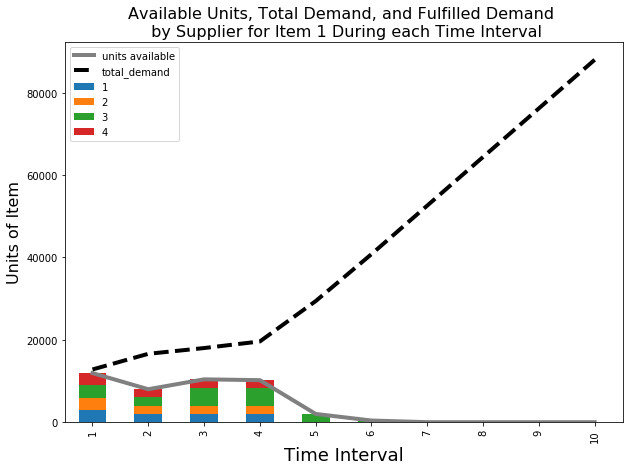

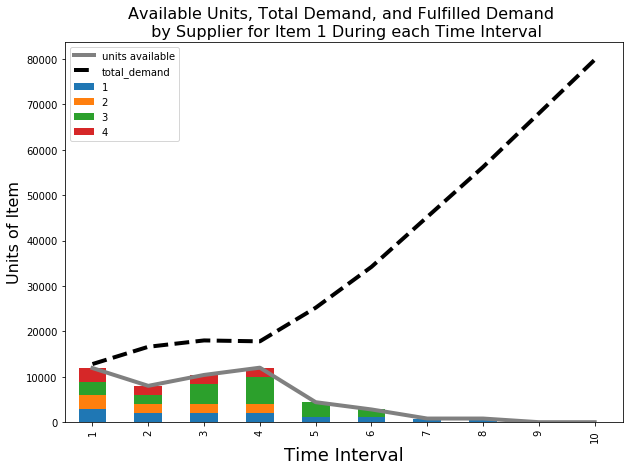

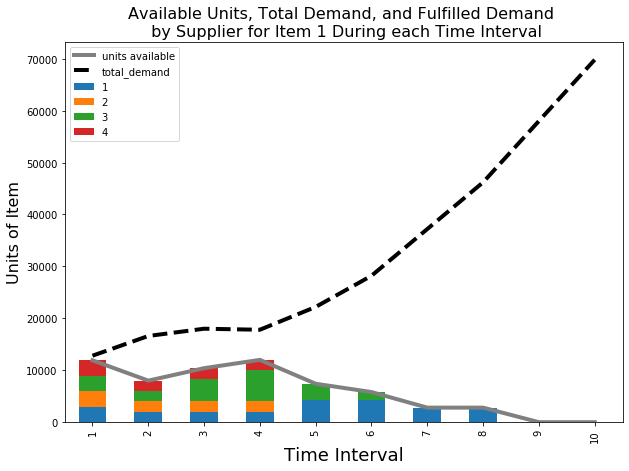

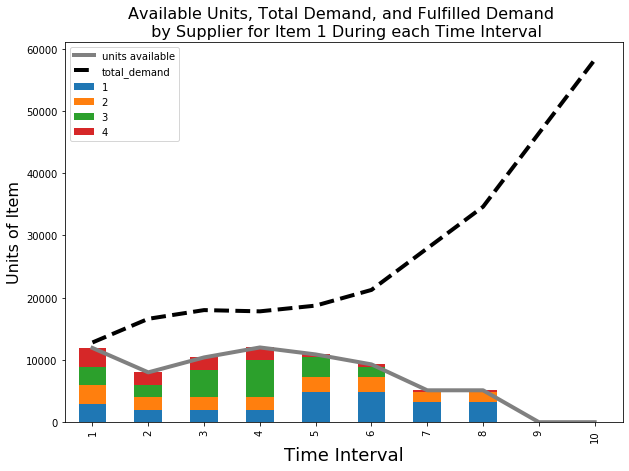

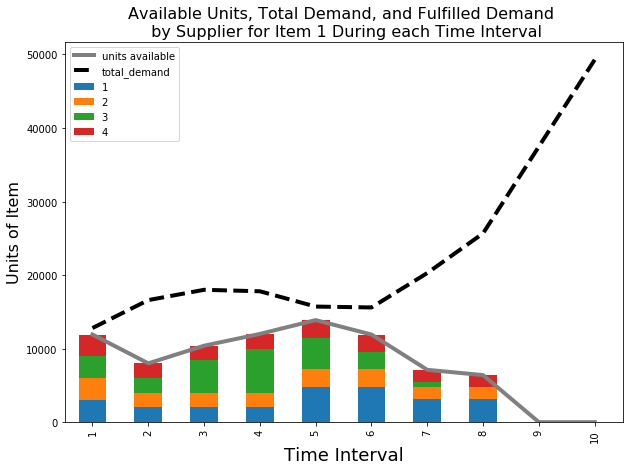

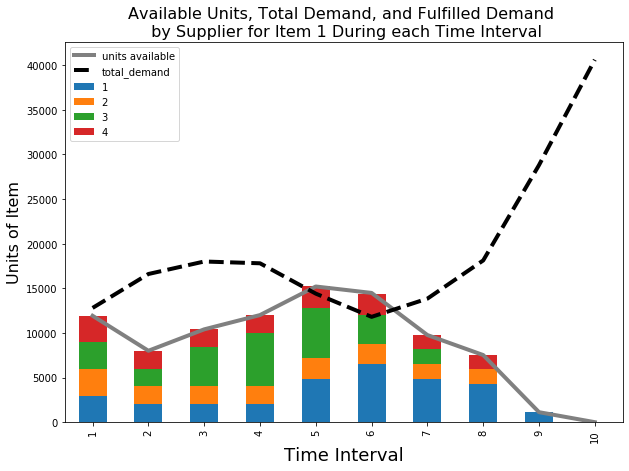

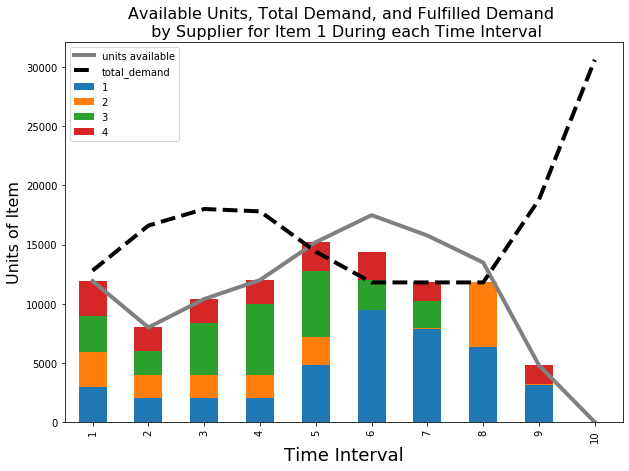

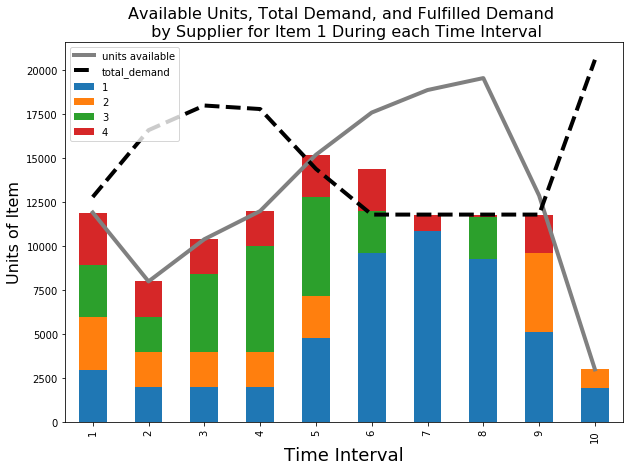

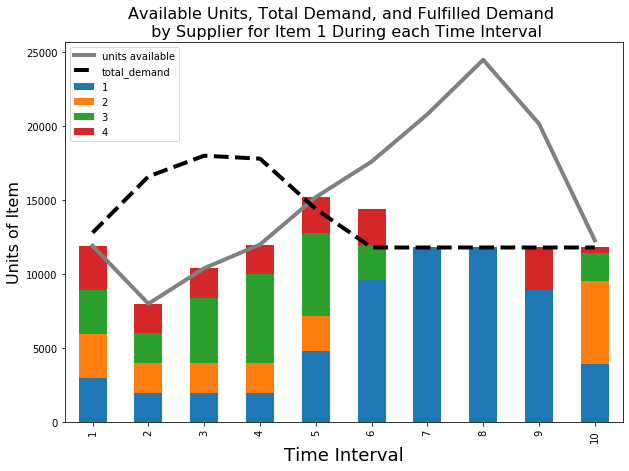

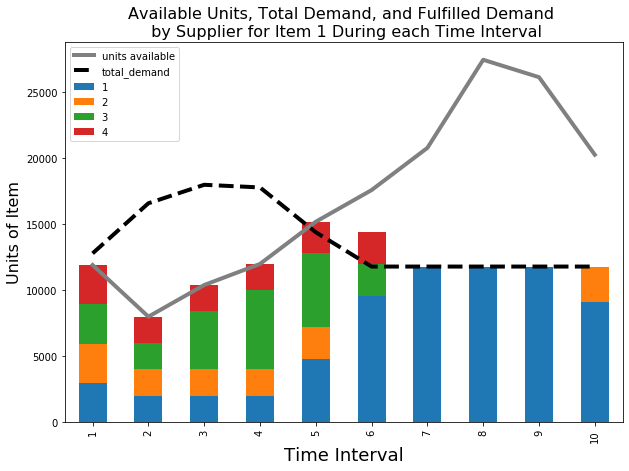

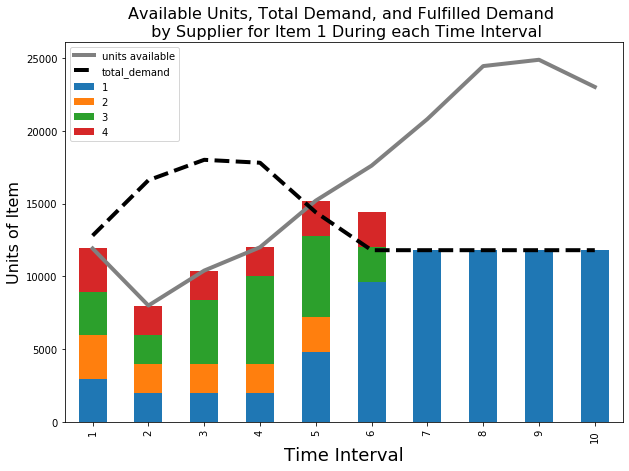

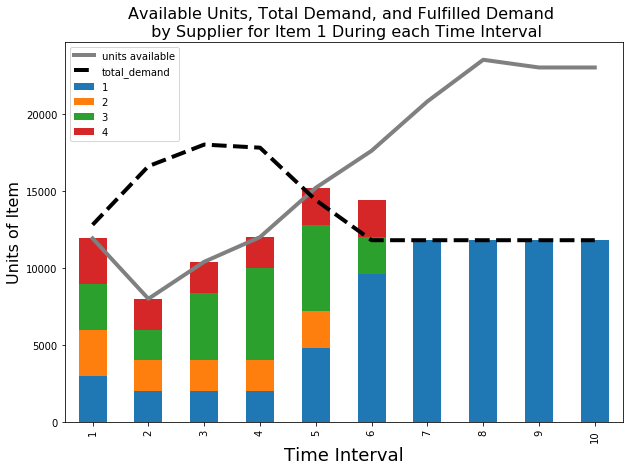

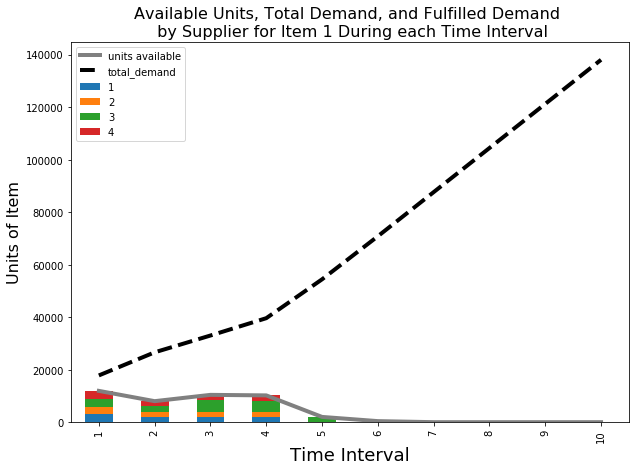

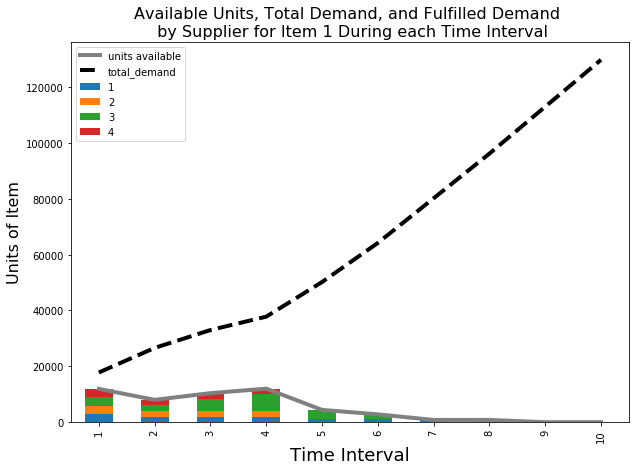

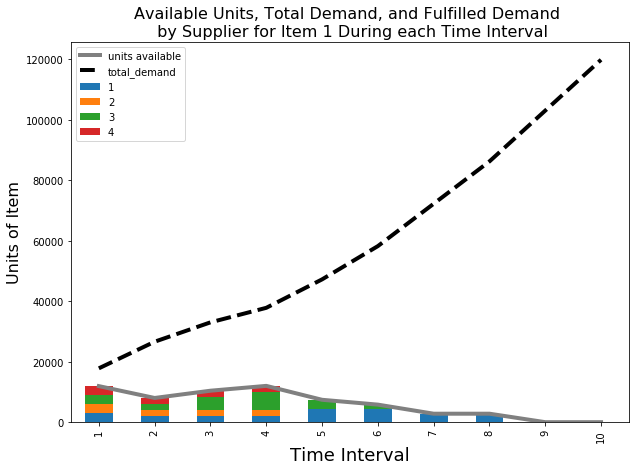

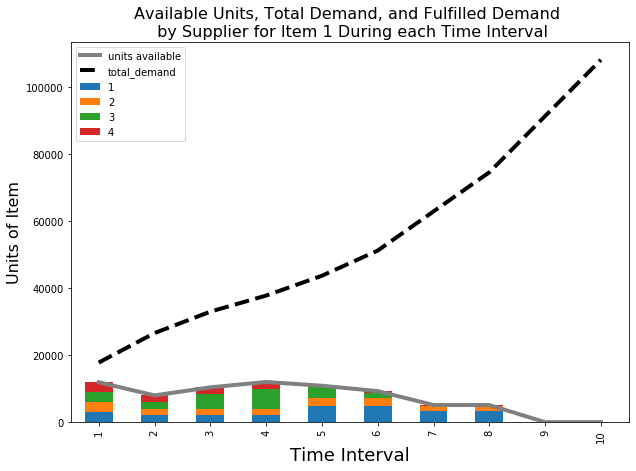

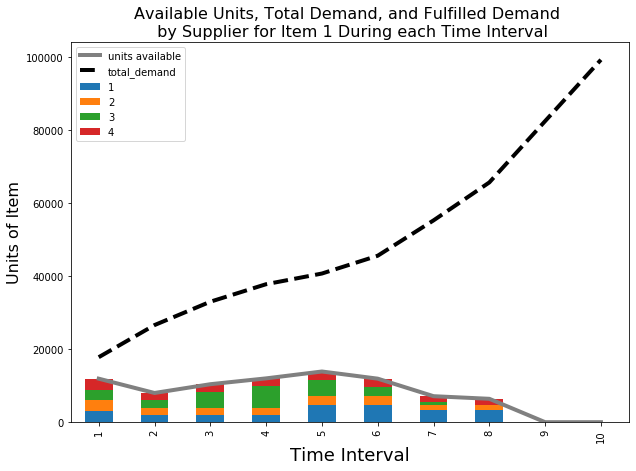

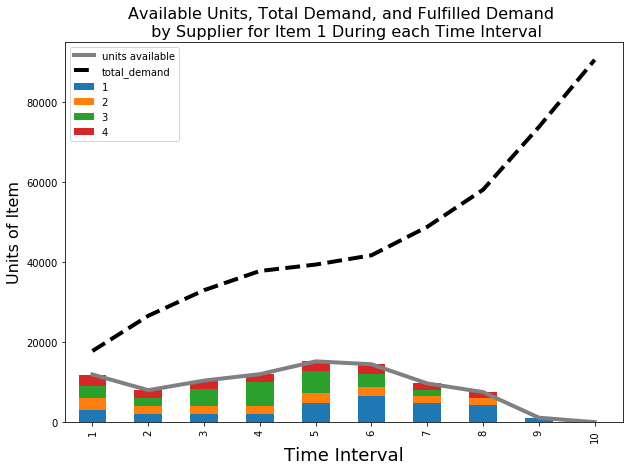

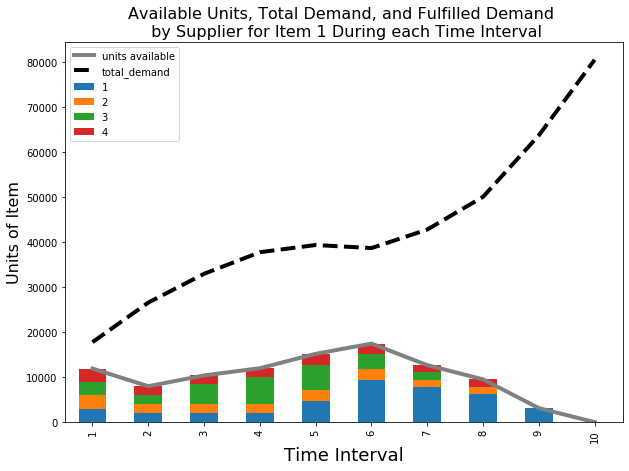

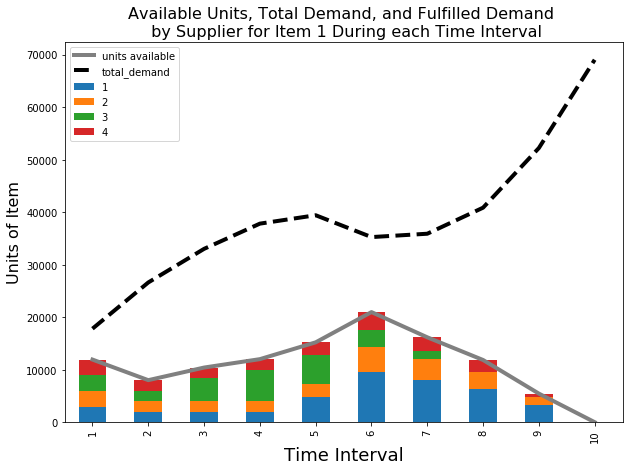

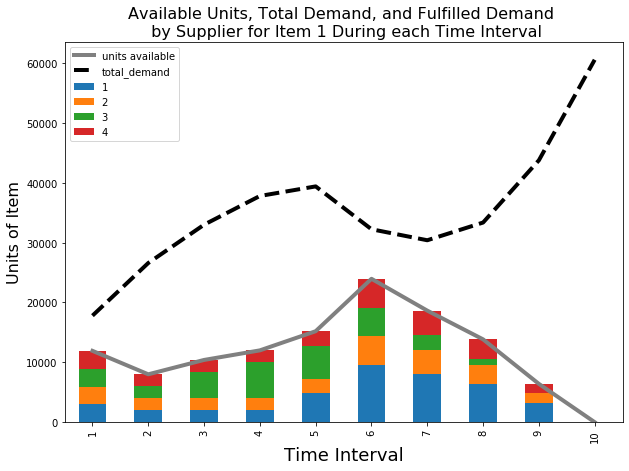

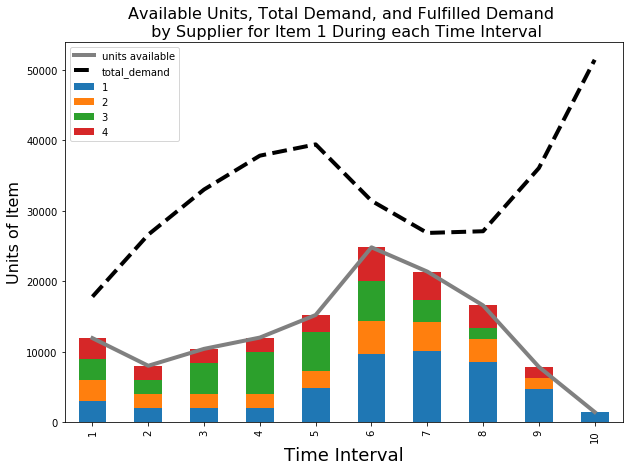

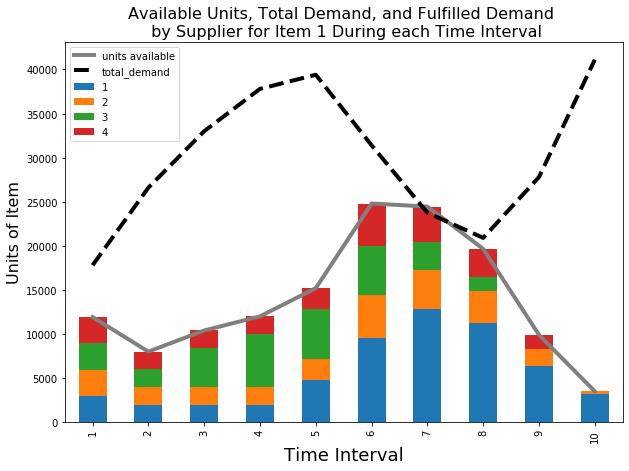

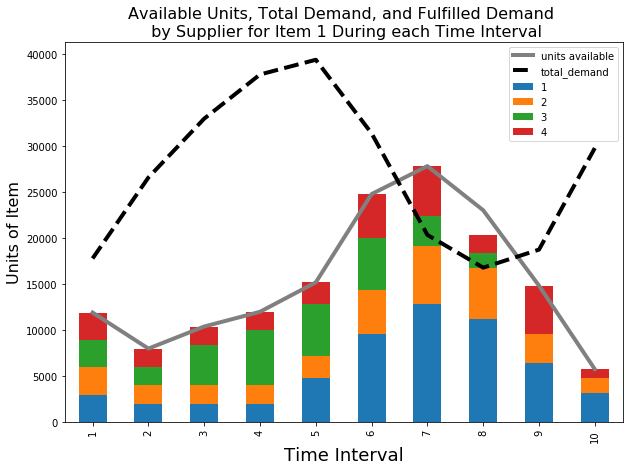

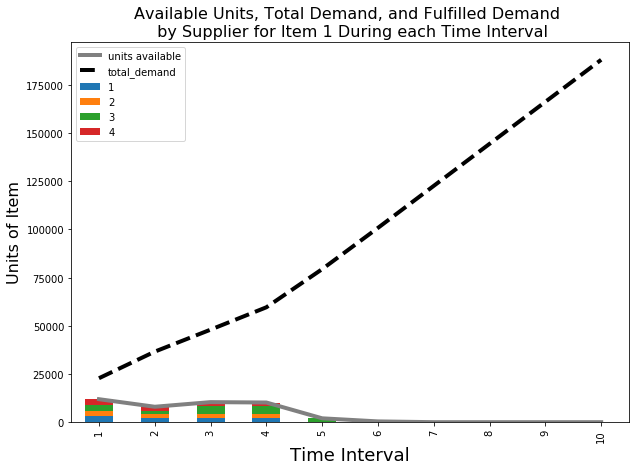

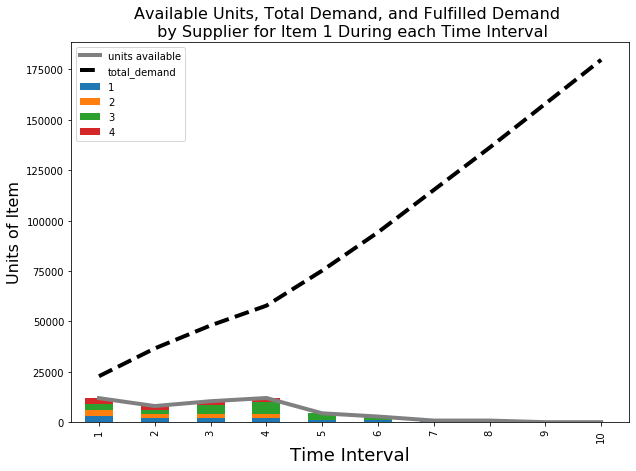

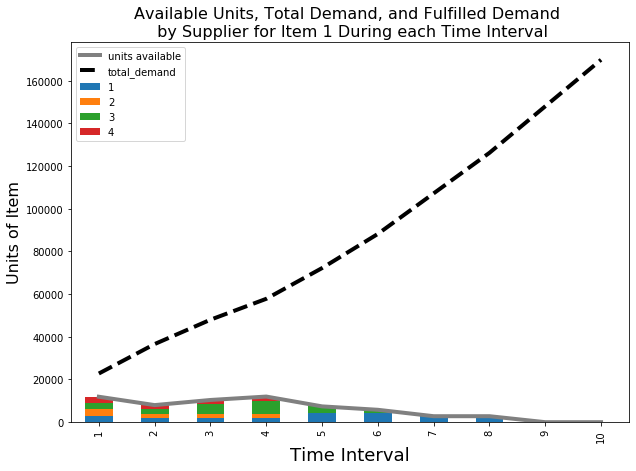

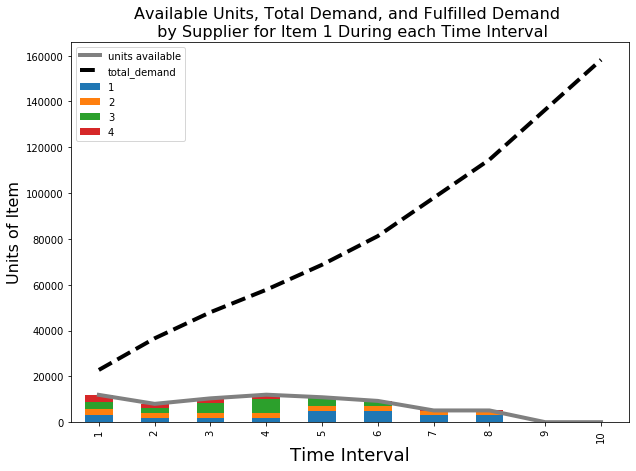

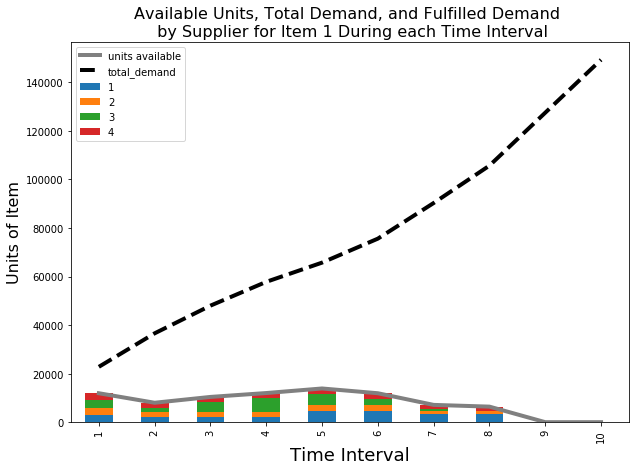

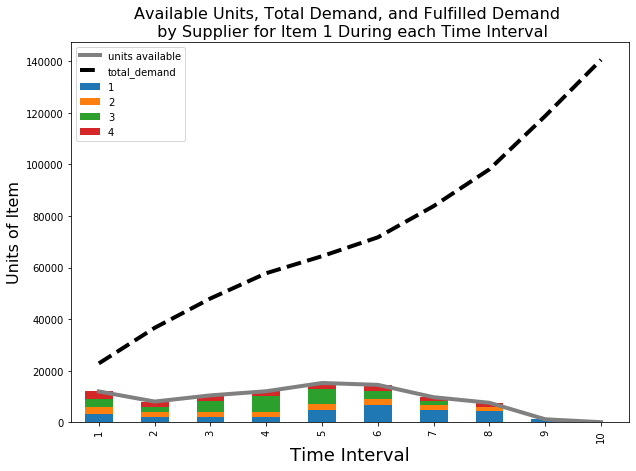

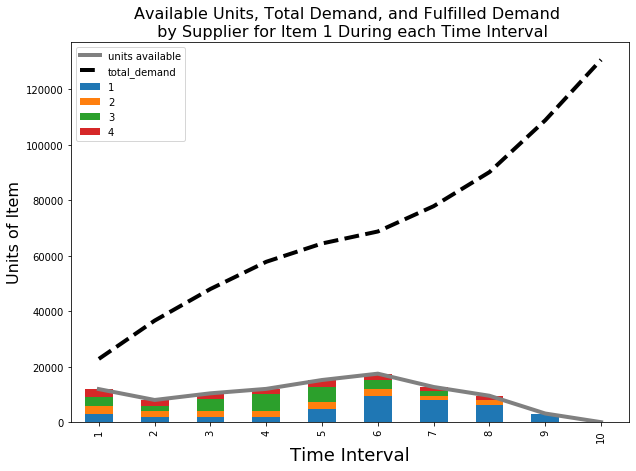

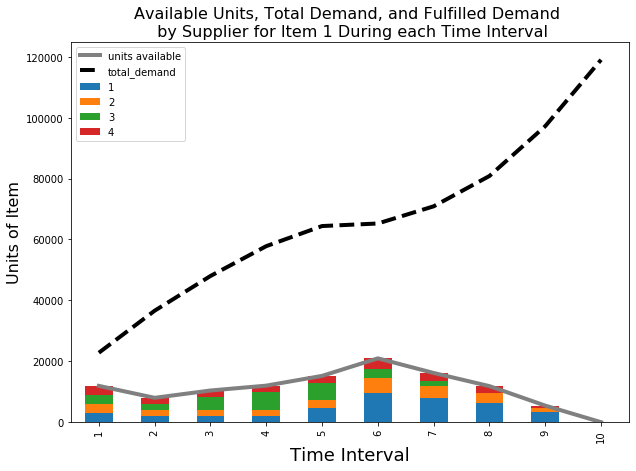

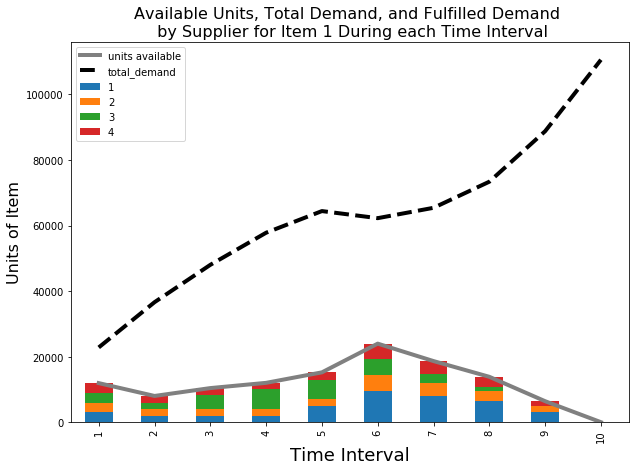

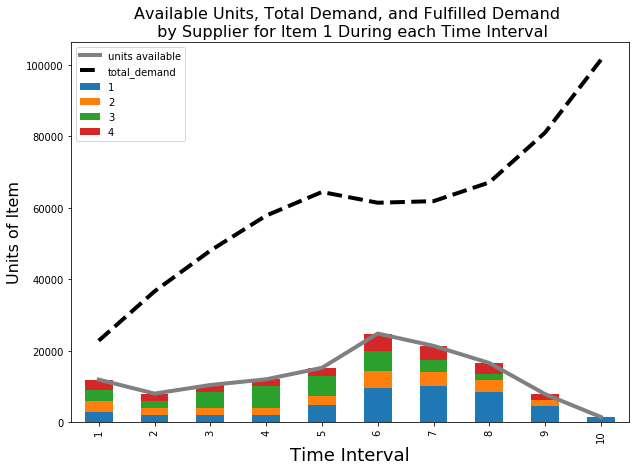

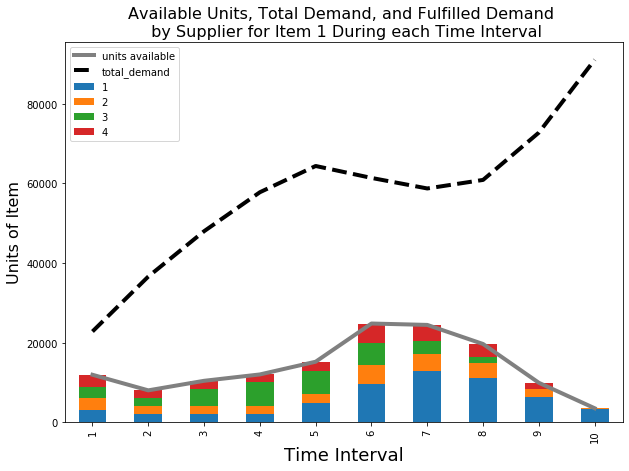

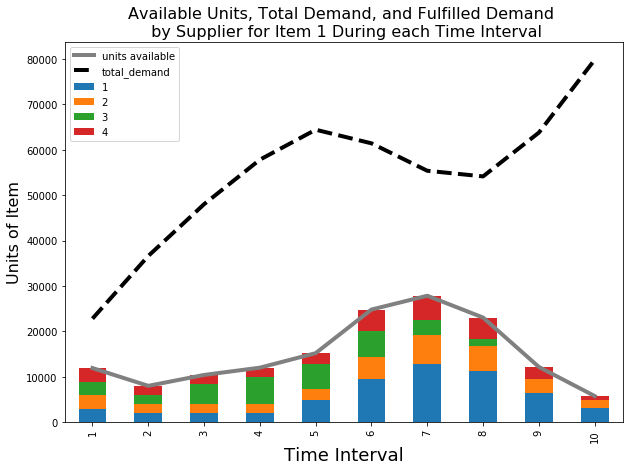

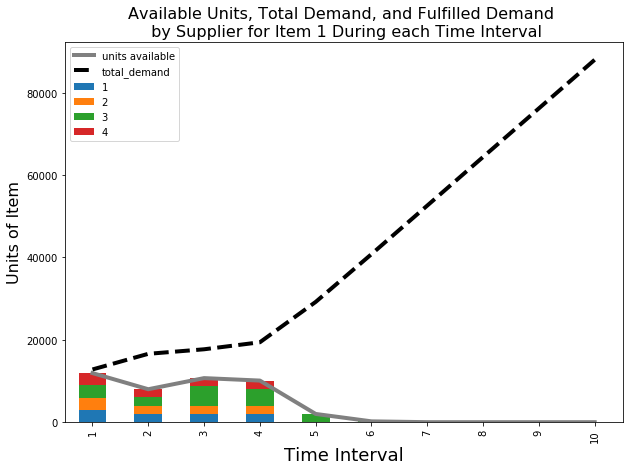

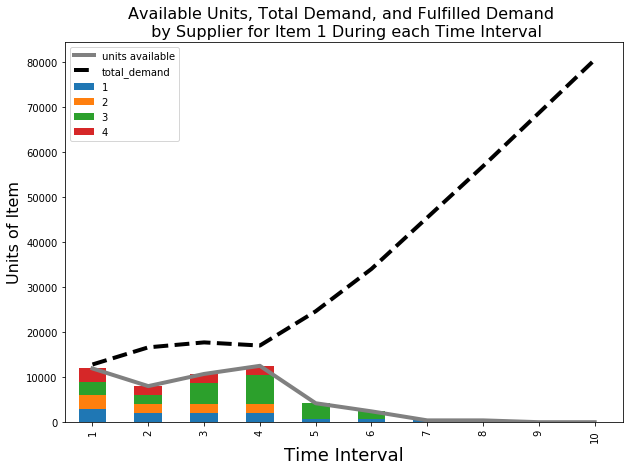

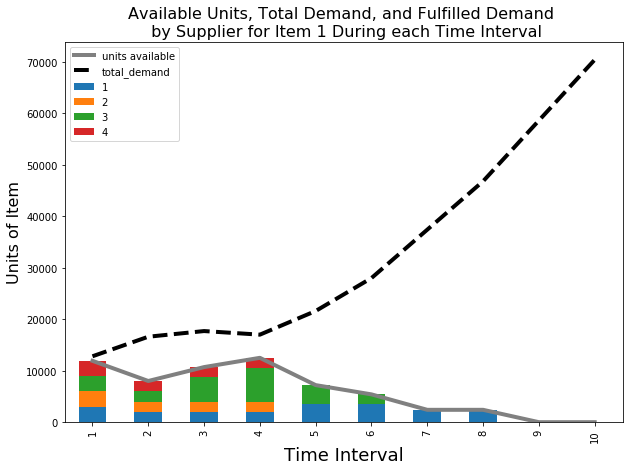

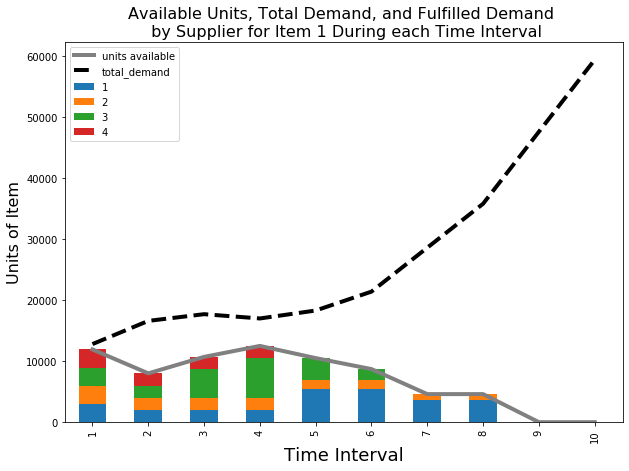

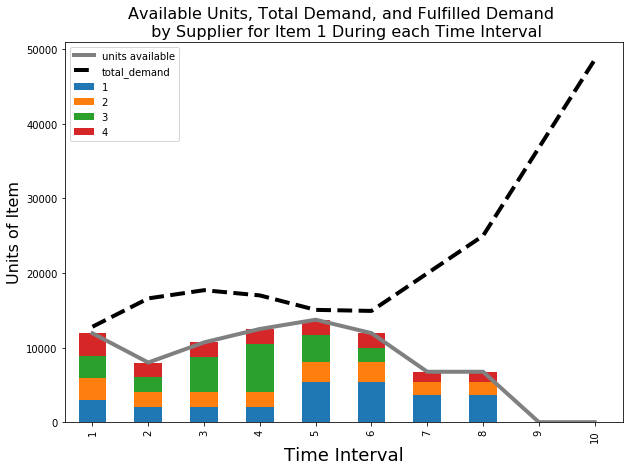

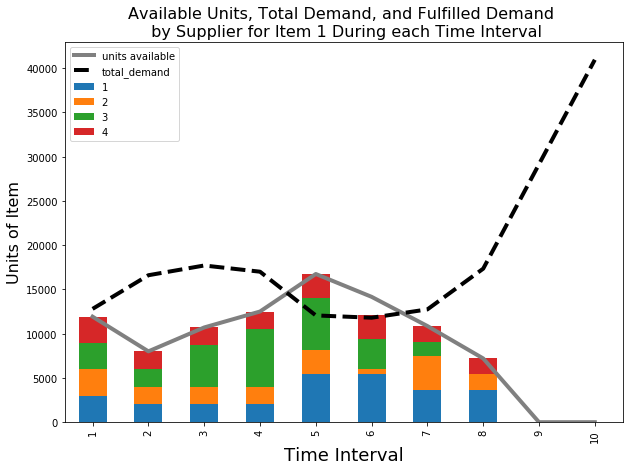

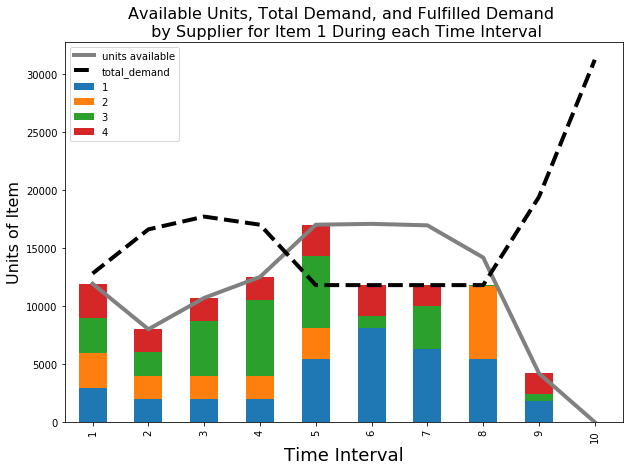

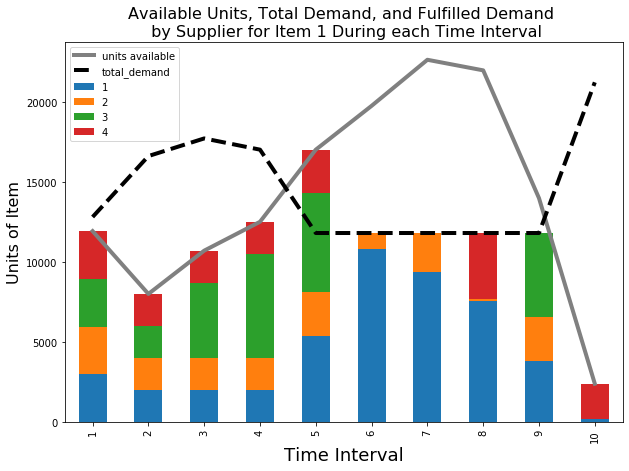

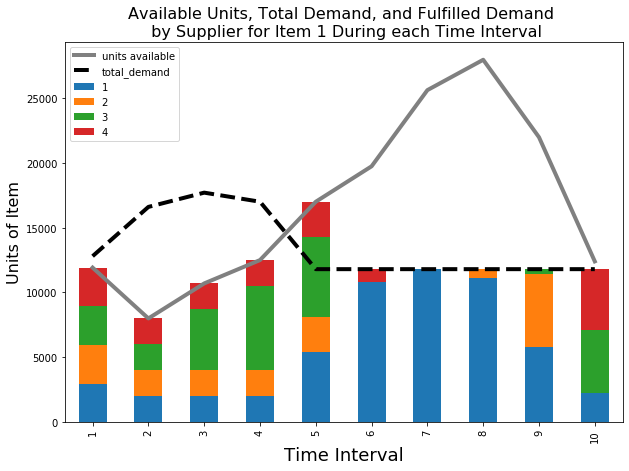

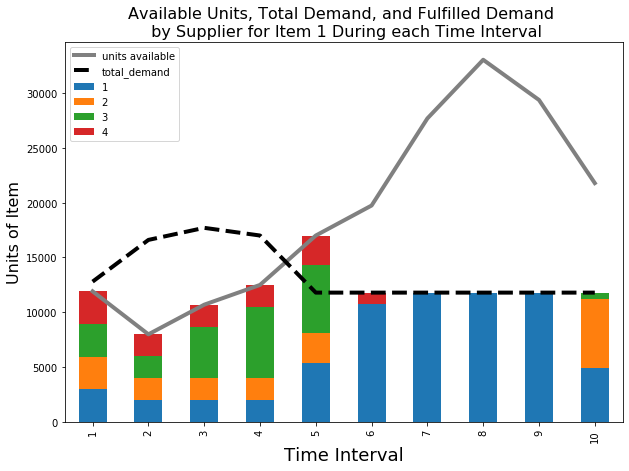

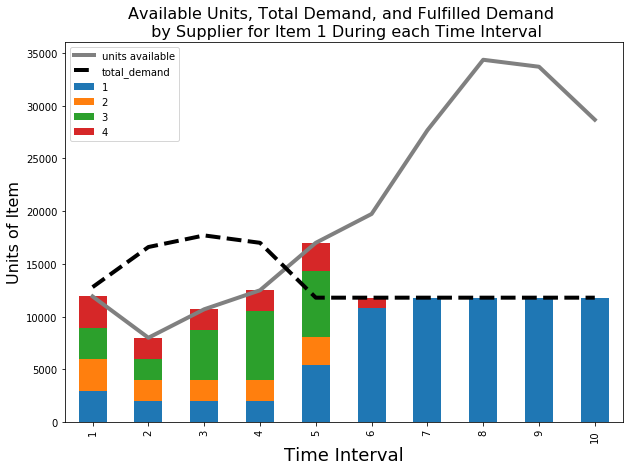

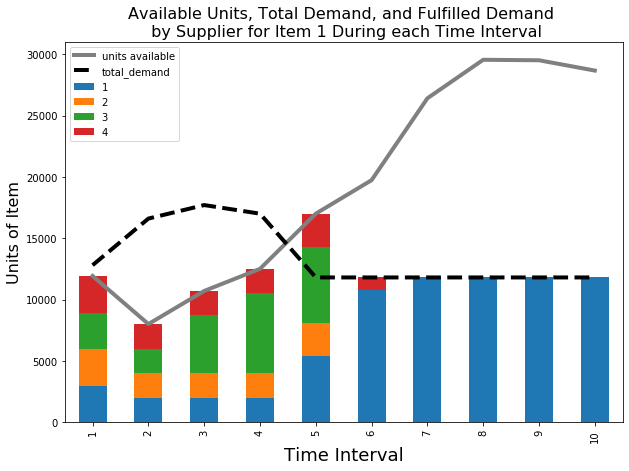

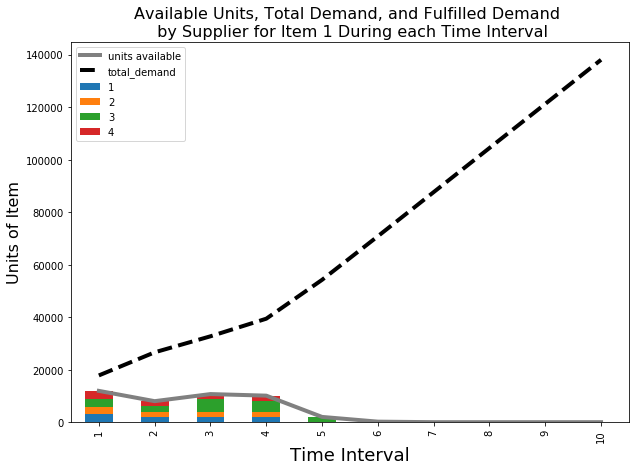

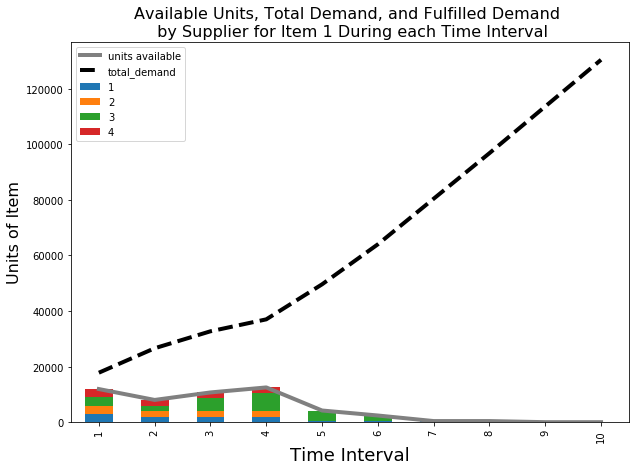

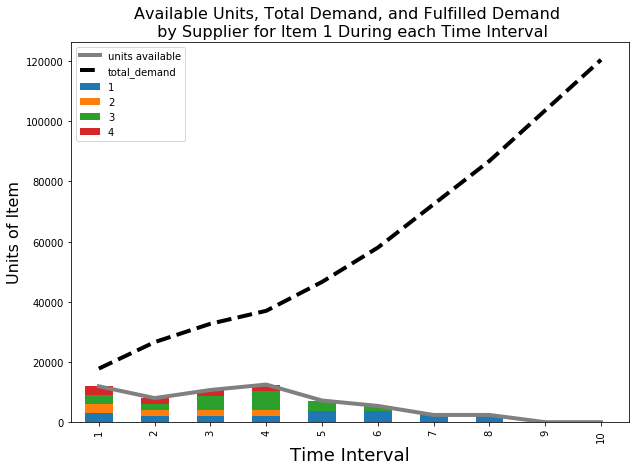

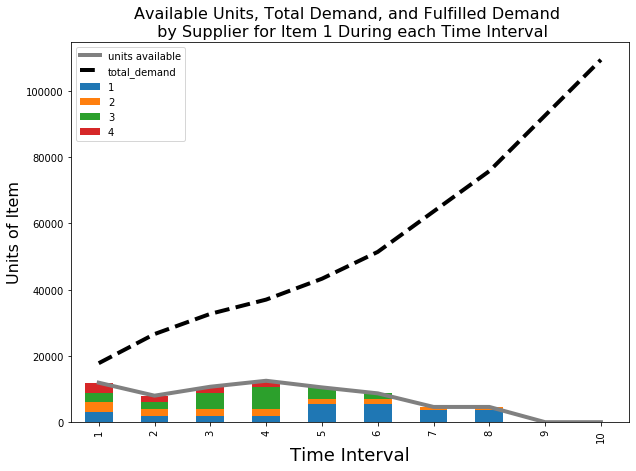

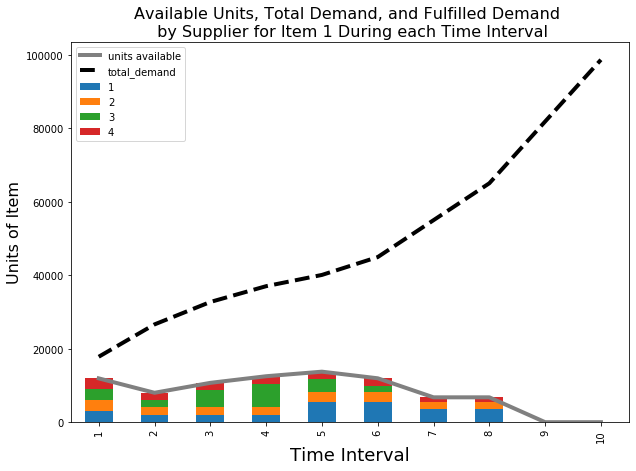

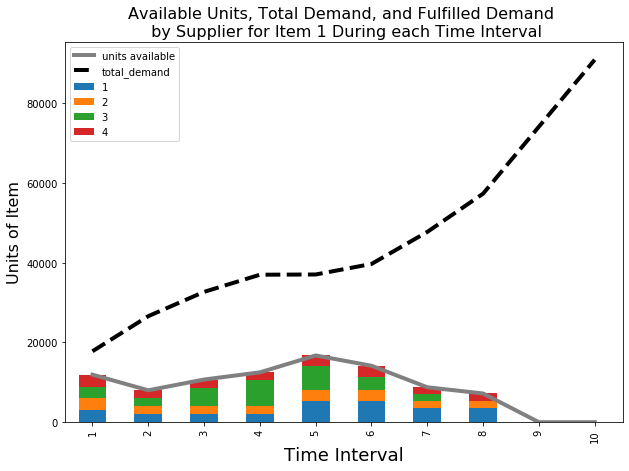

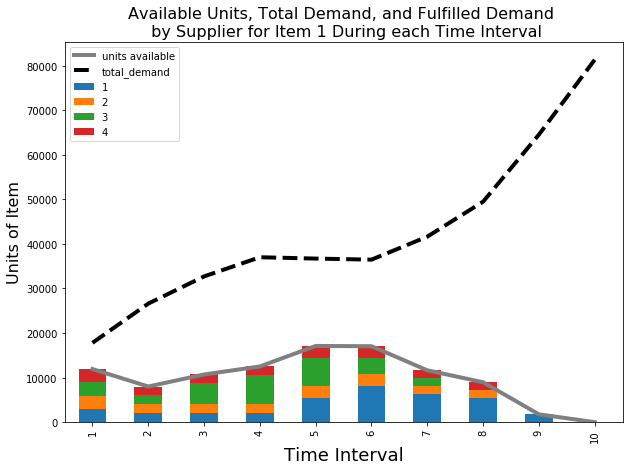

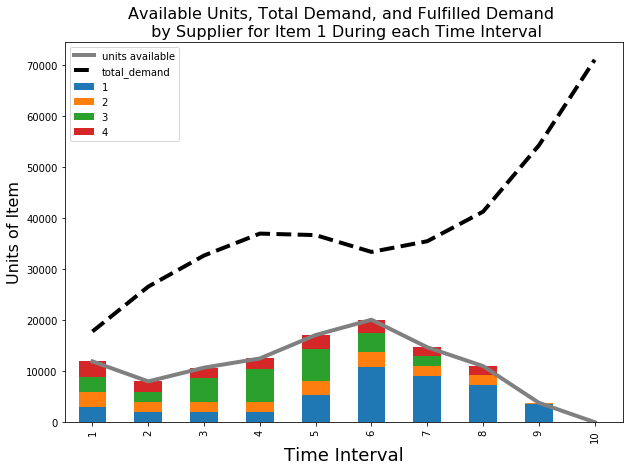

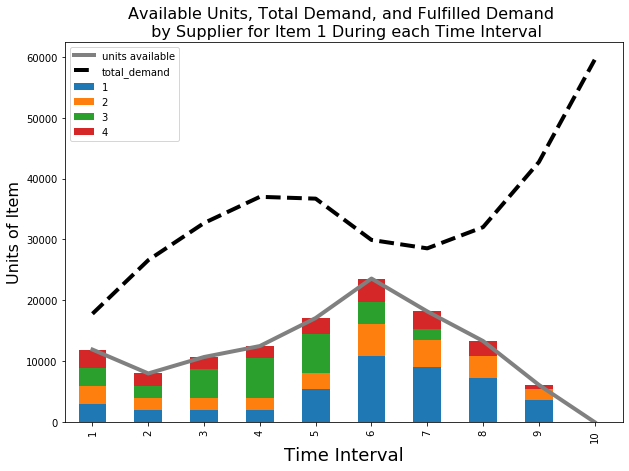

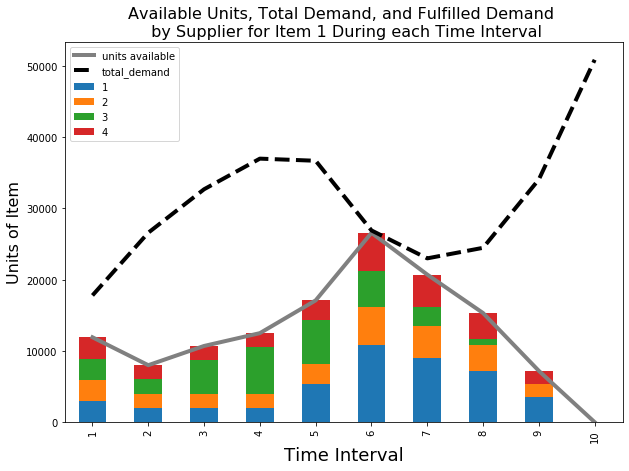

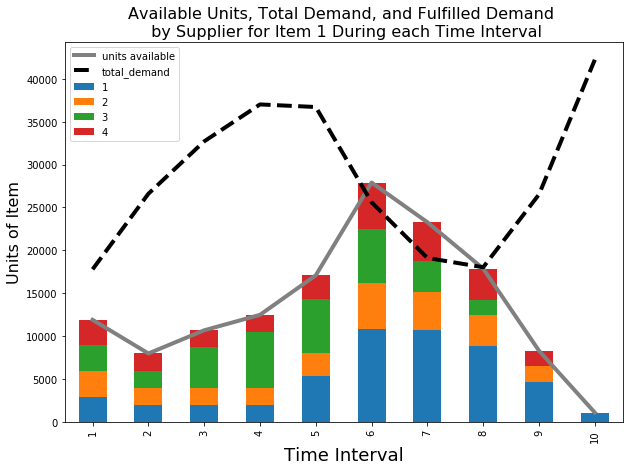

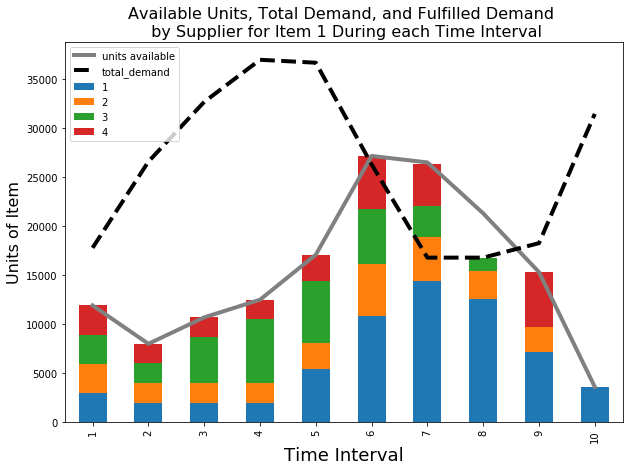

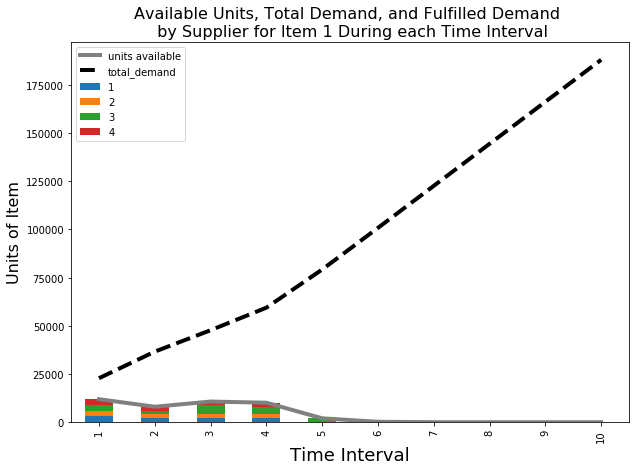

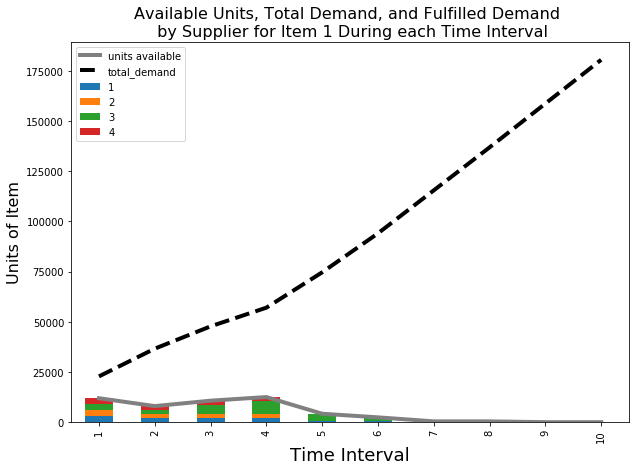

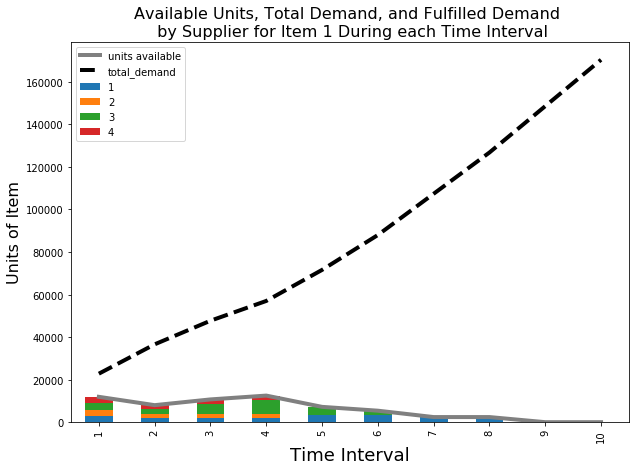

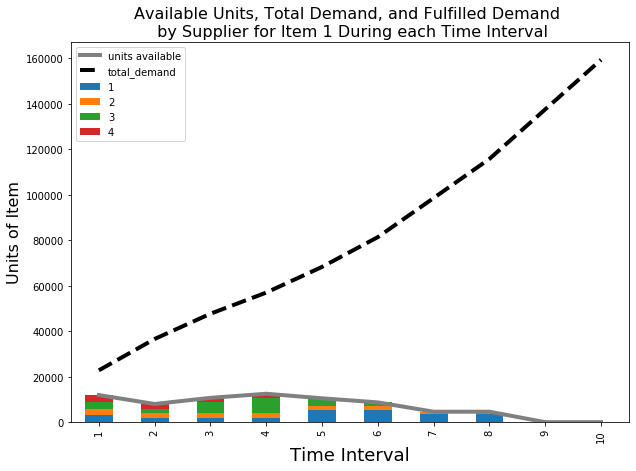

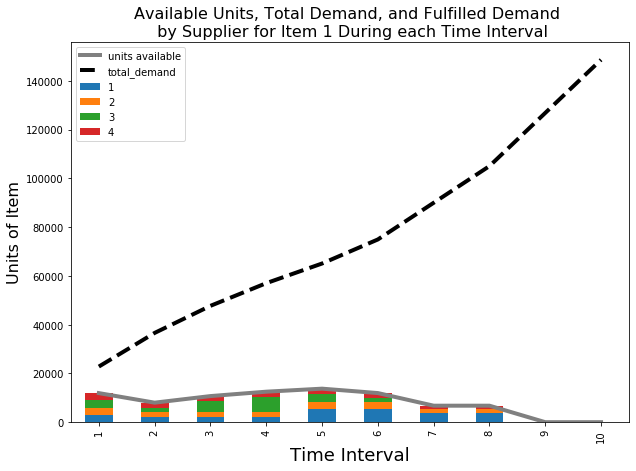

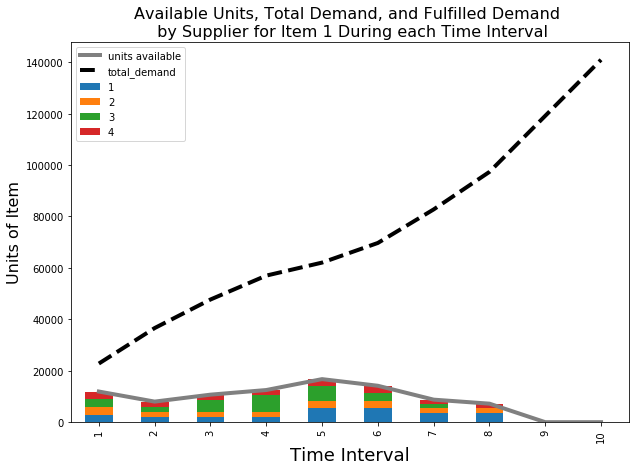

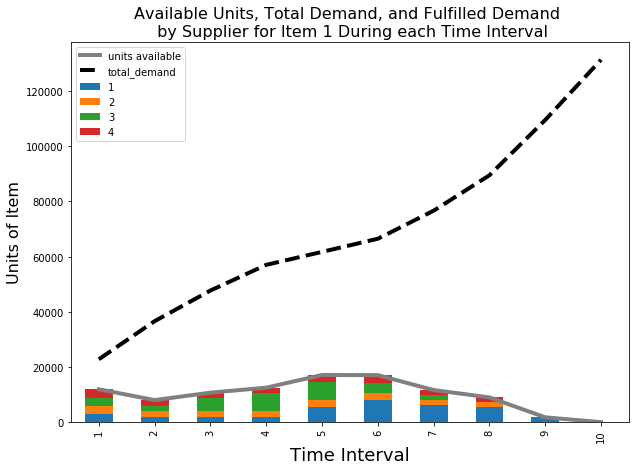

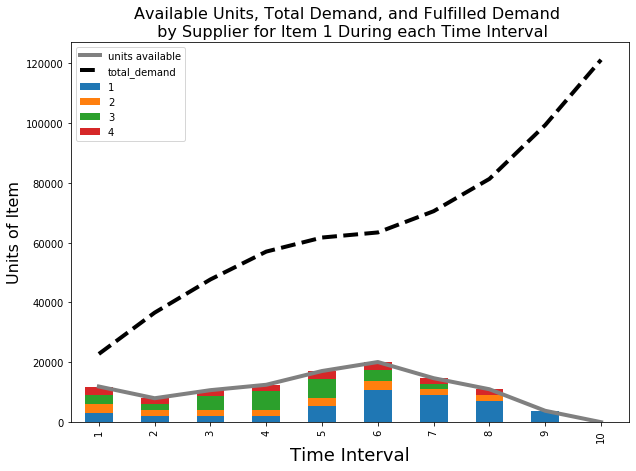

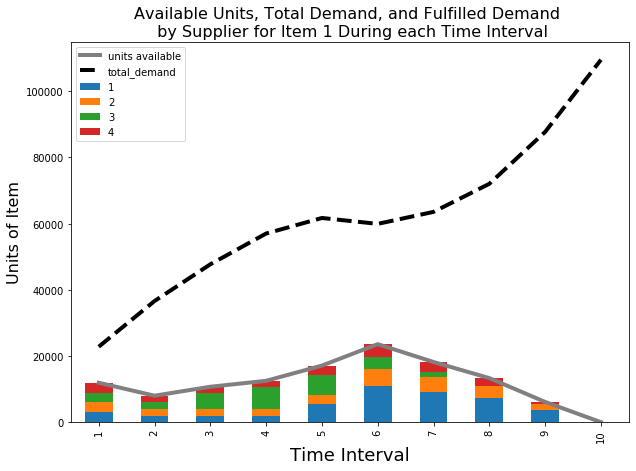

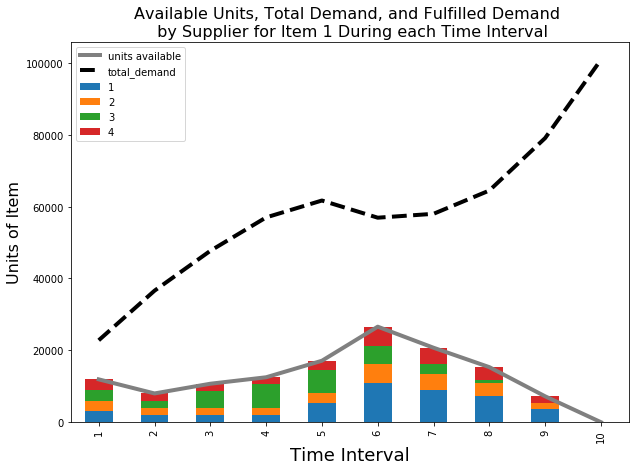

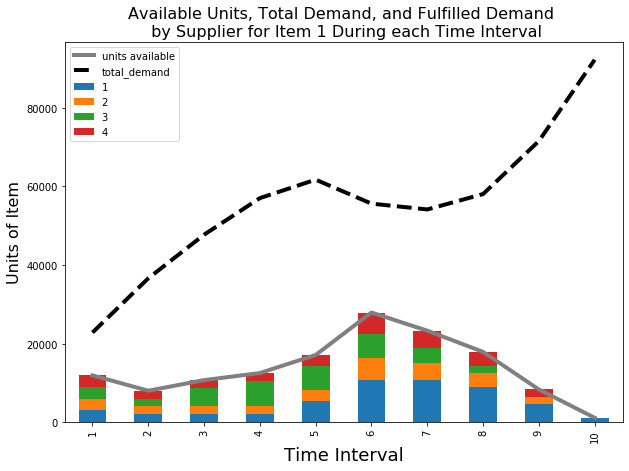

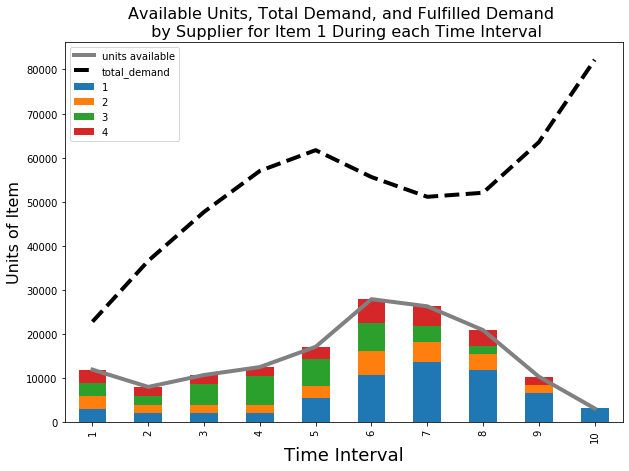

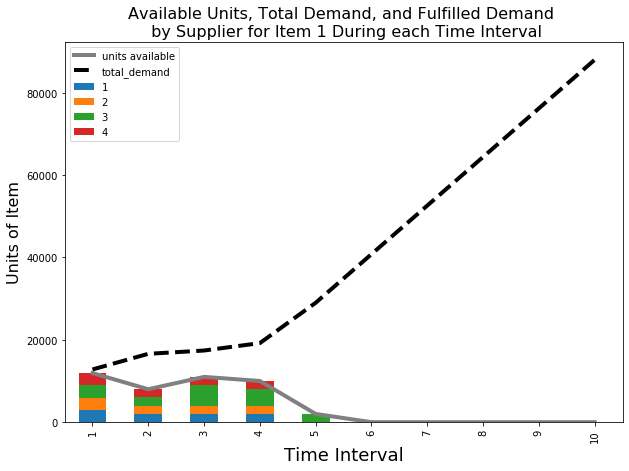

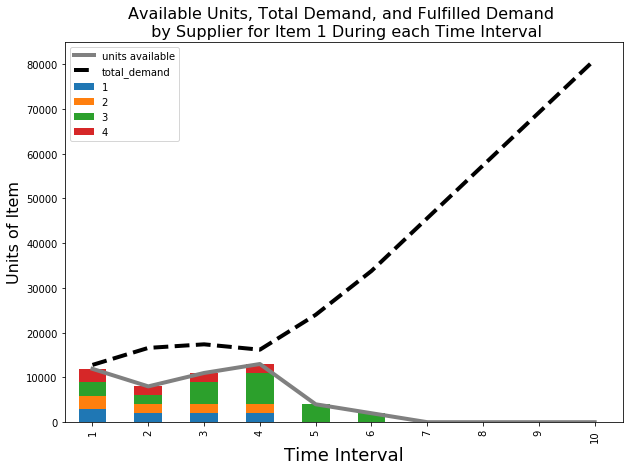

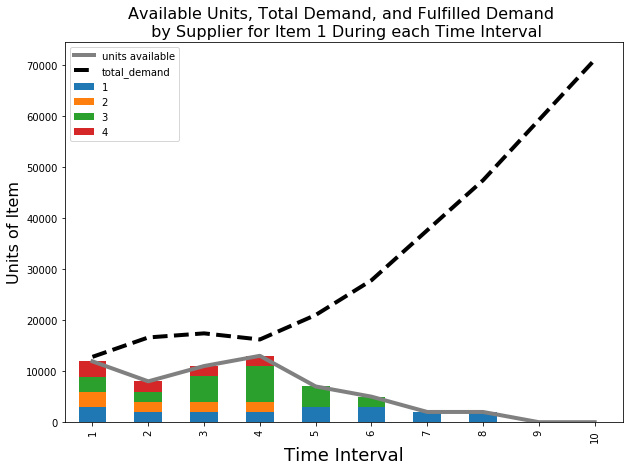

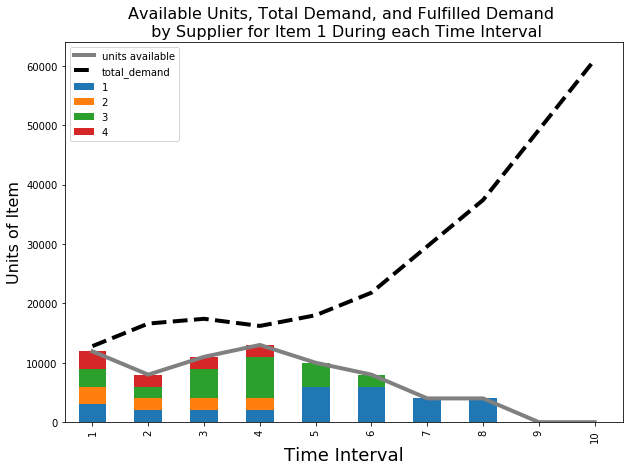

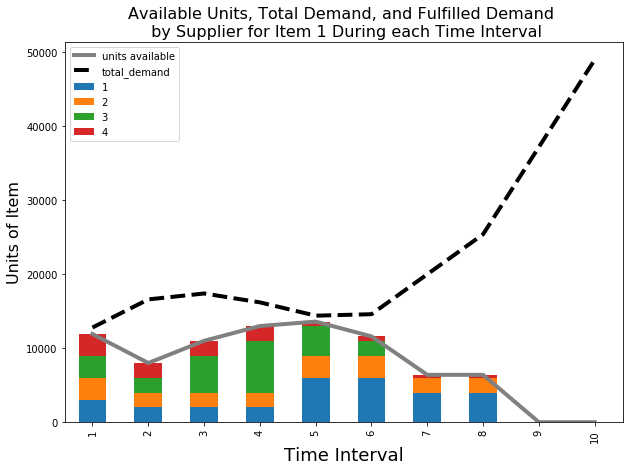

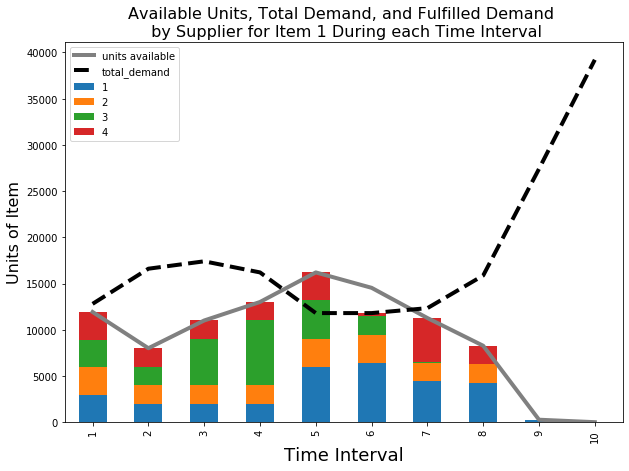

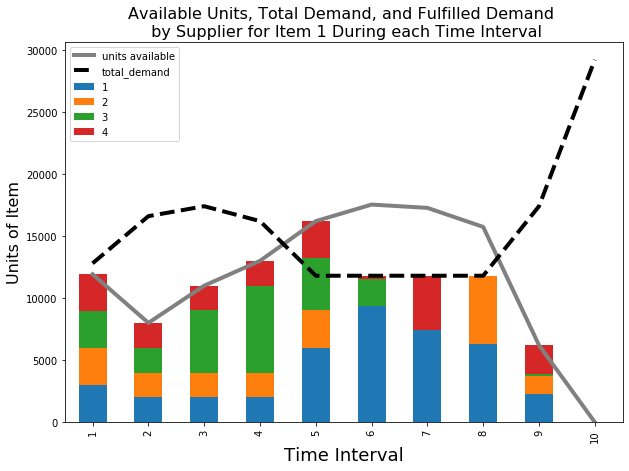

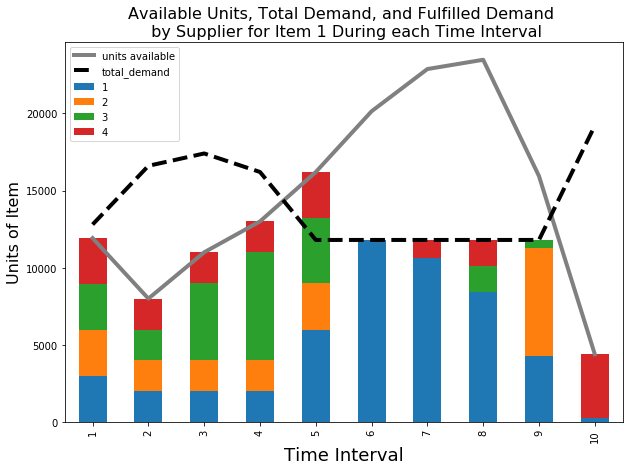

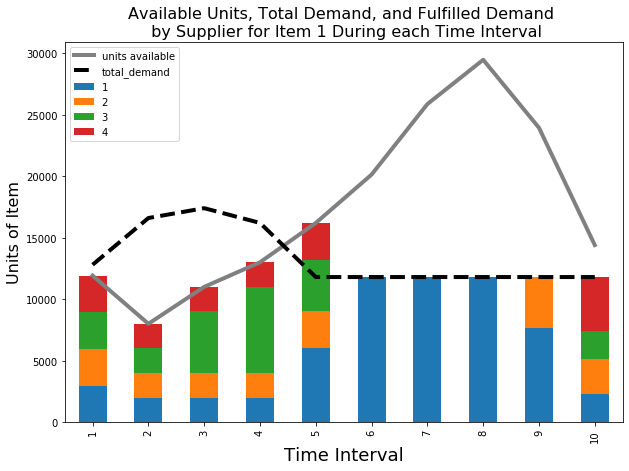

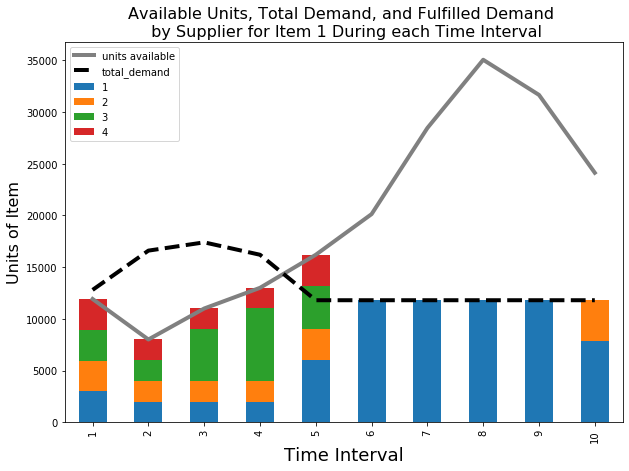

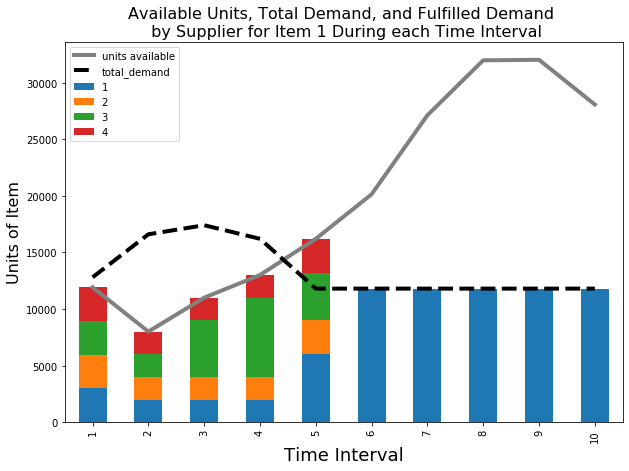

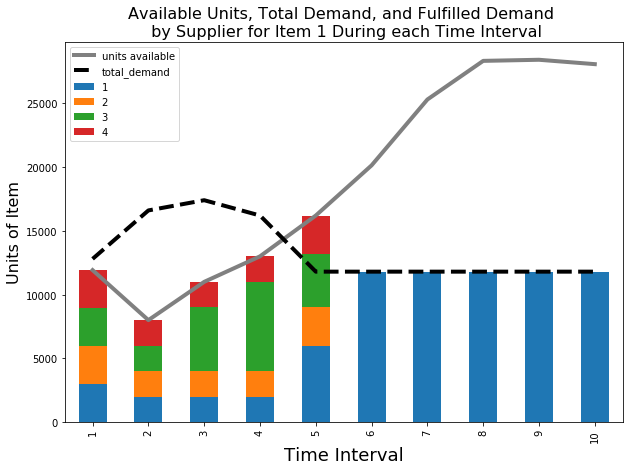

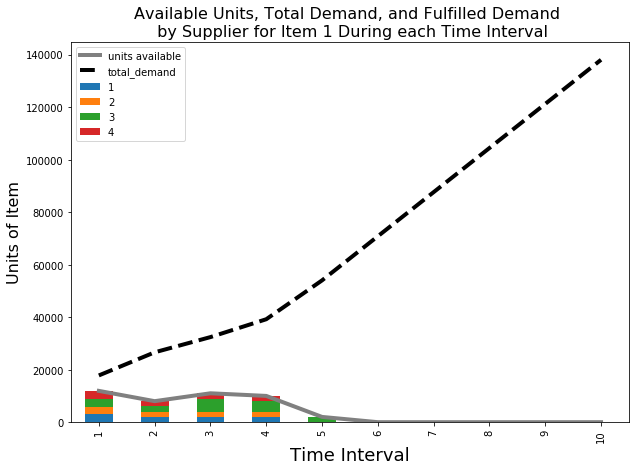

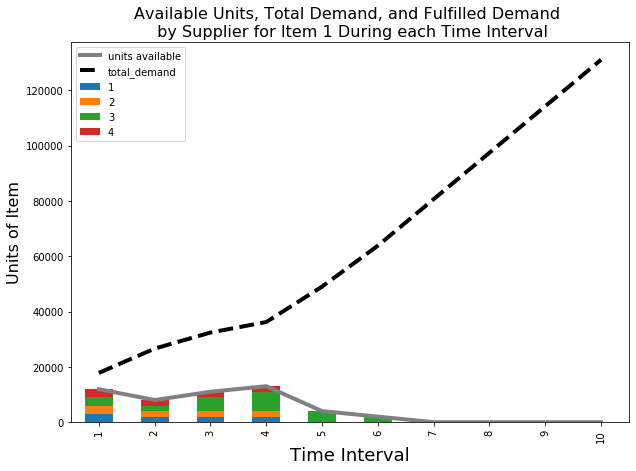

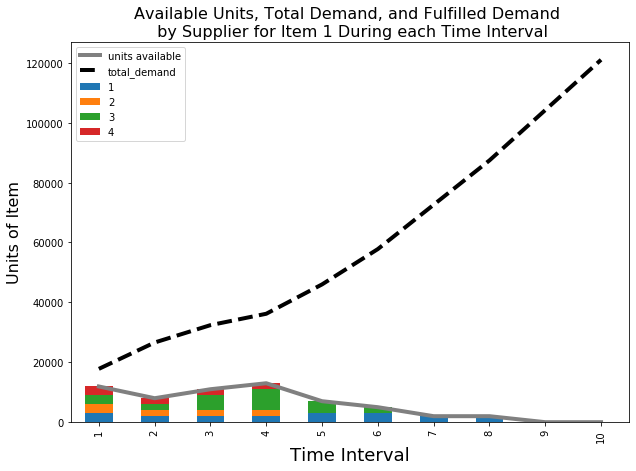

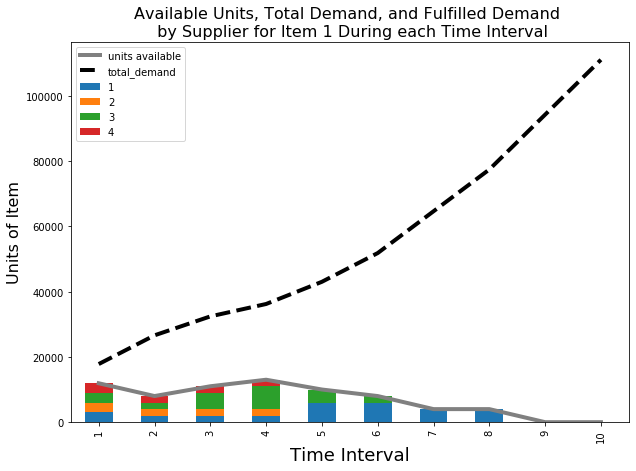

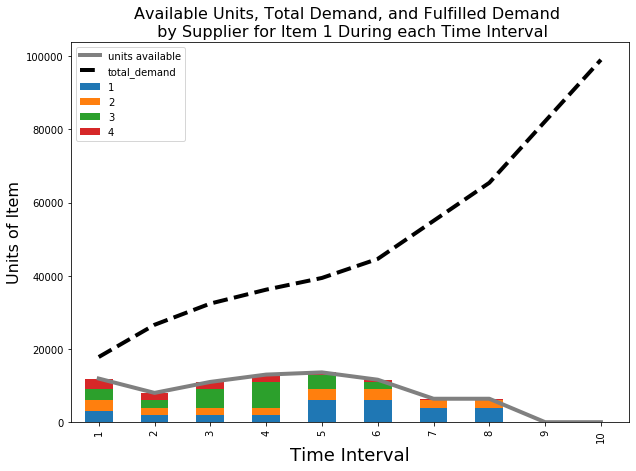

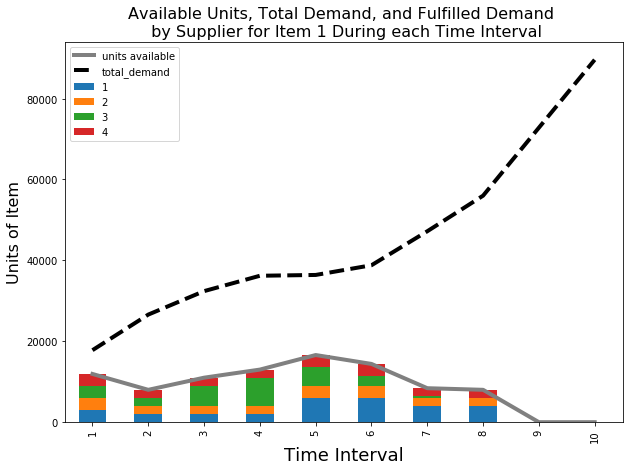

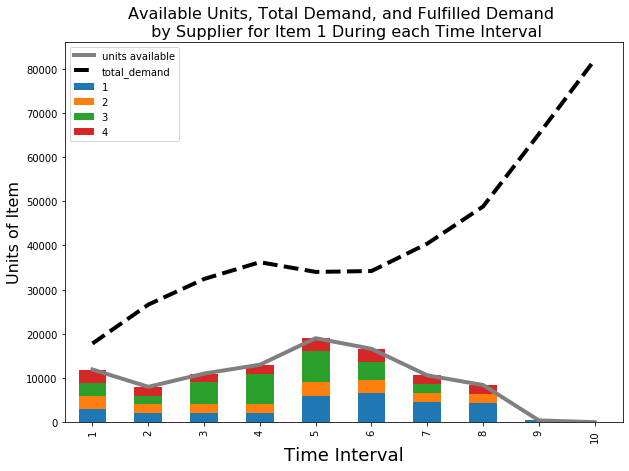

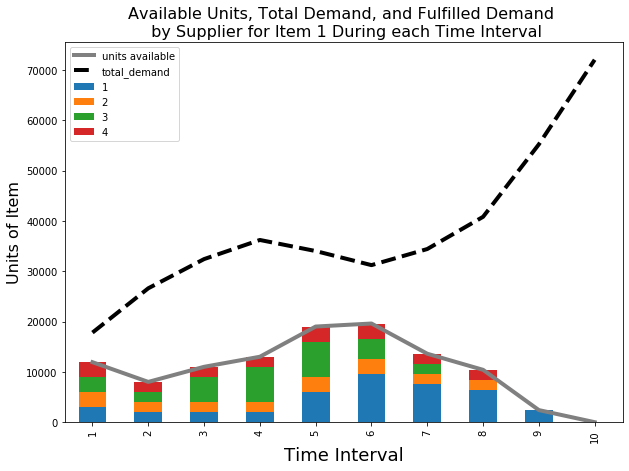

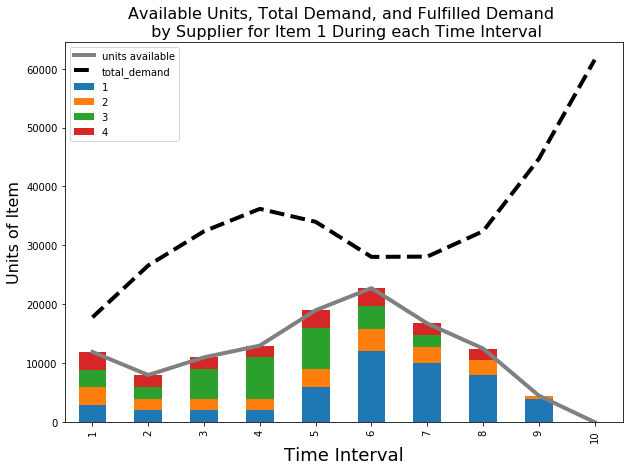

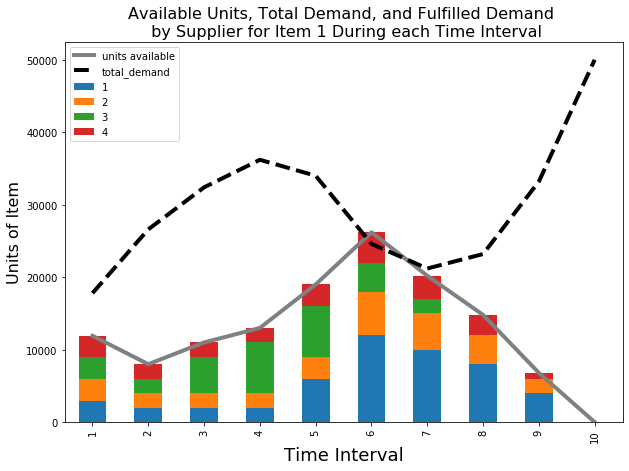

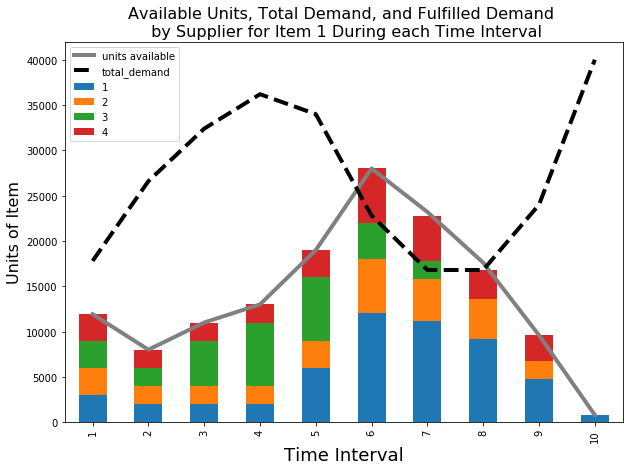

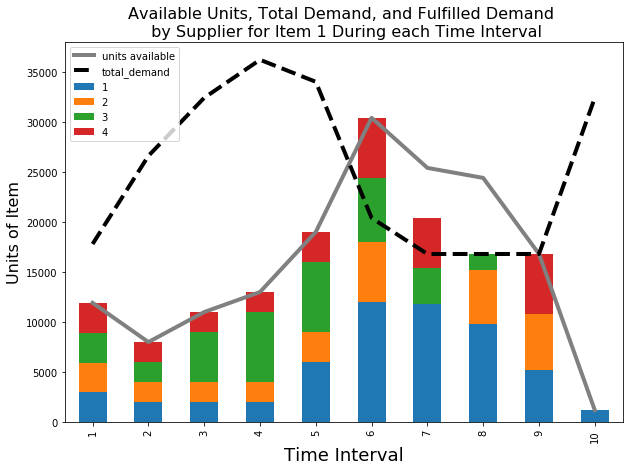

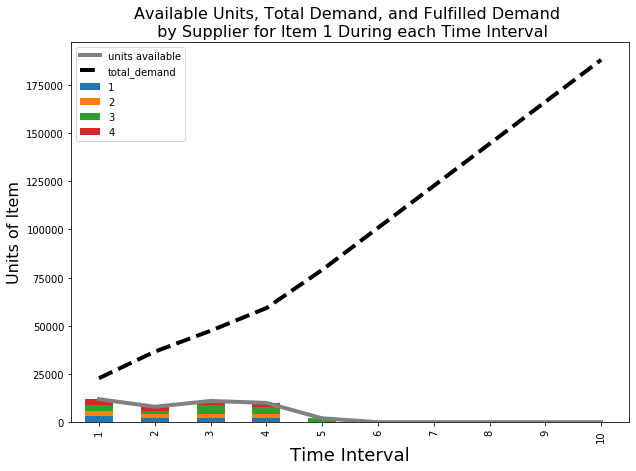

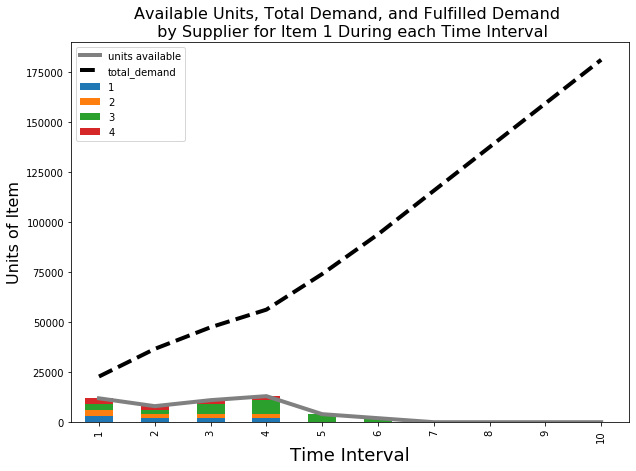

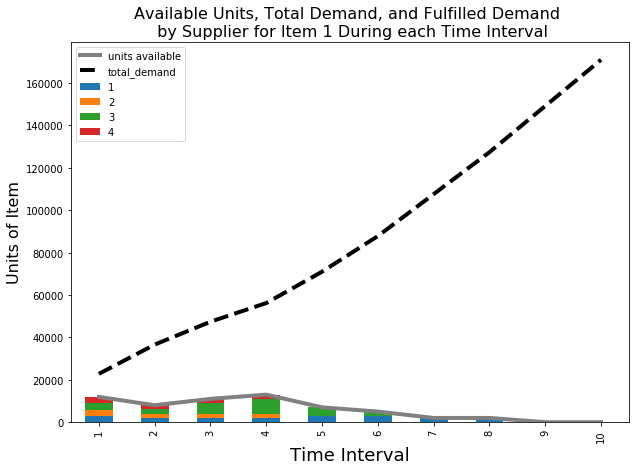

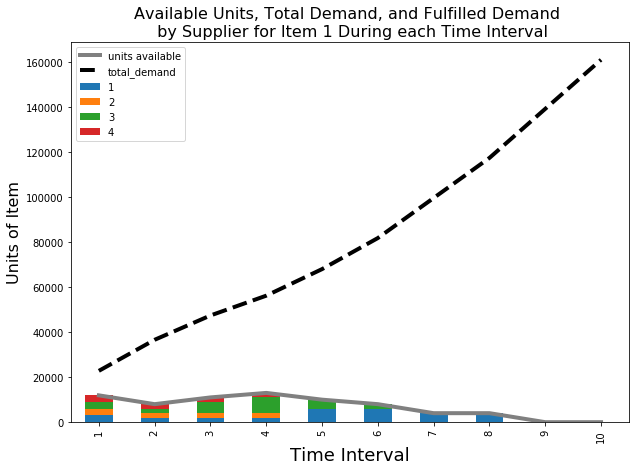

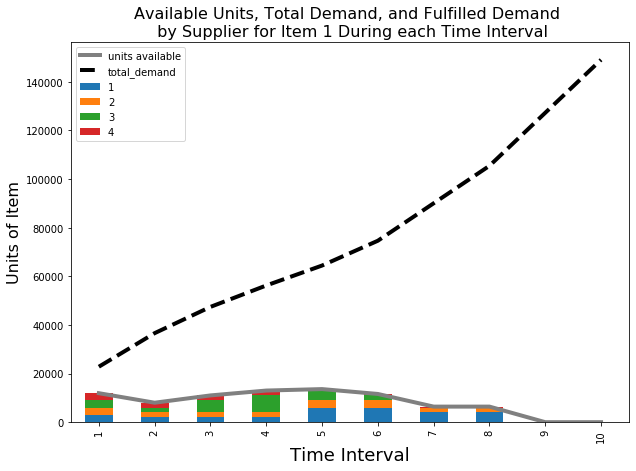

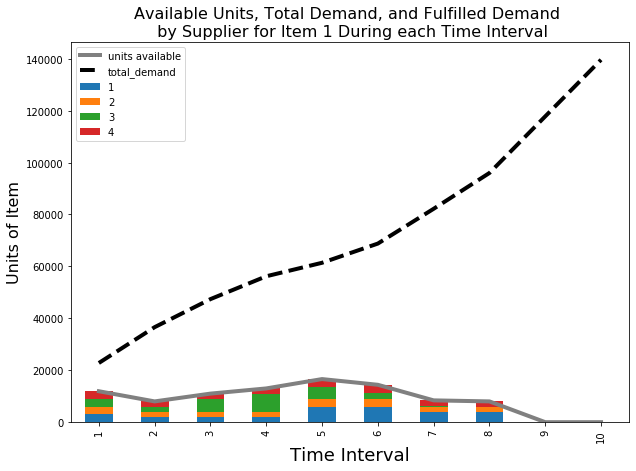

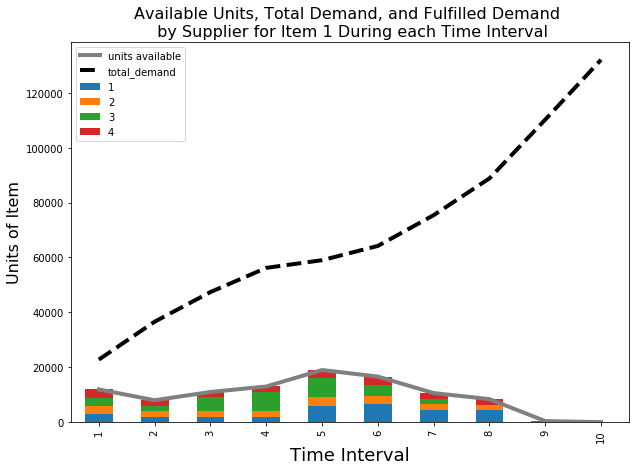

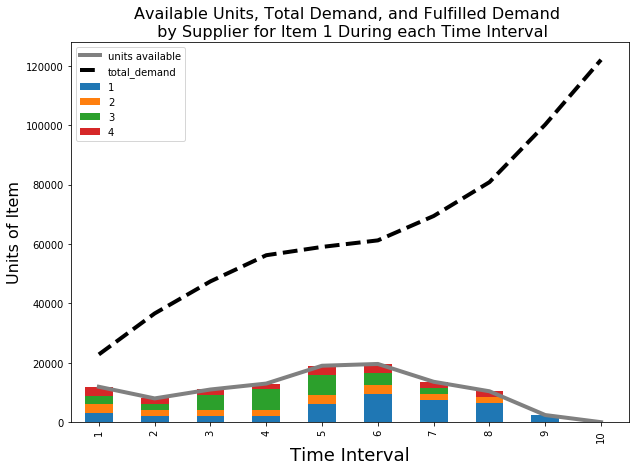

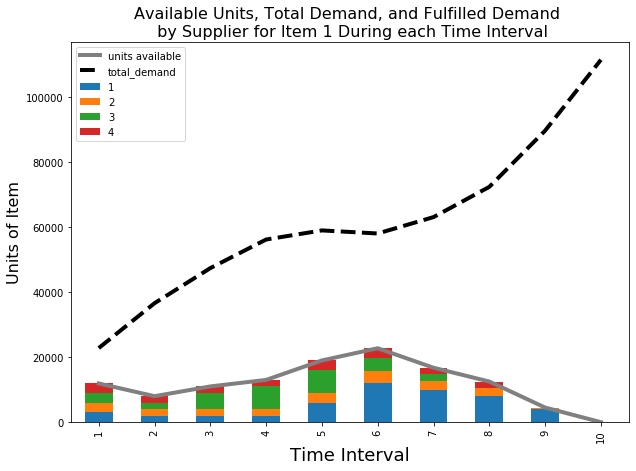

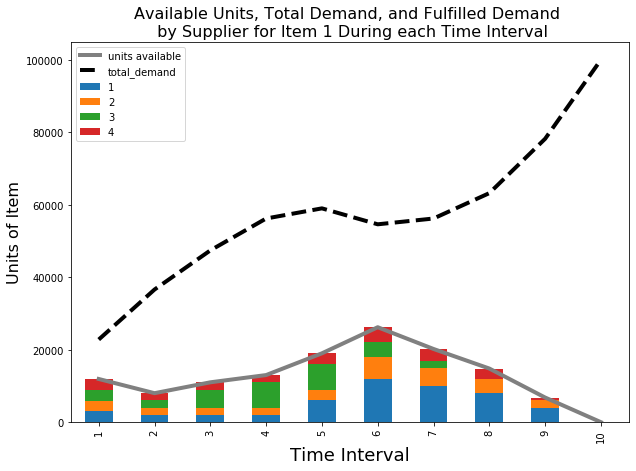

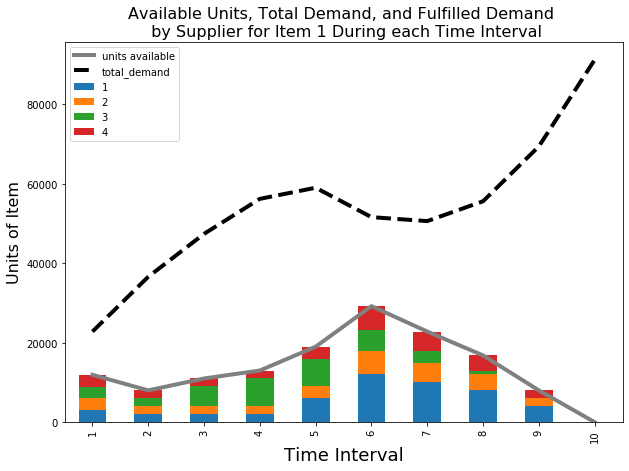

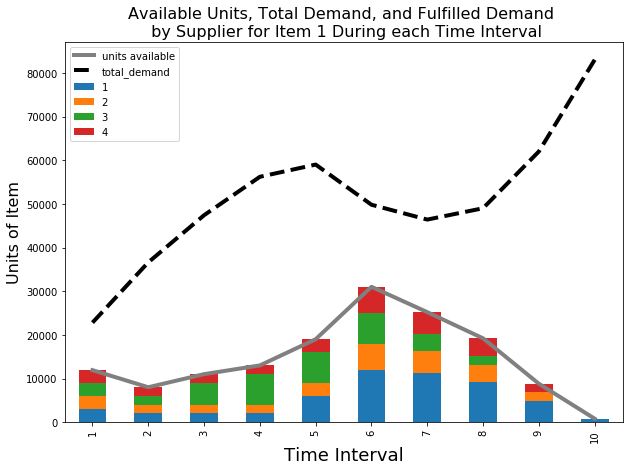

In [9]:
for c in CAP_reliability:
    for d in DEMAND_reliability:
        for b in budget_levels:
            model = initialize_model(c, d, b)
            model = initialize_objective(model)
            model = initialize_constraints(model)
            
            opt = pyomo.opt.SolverFactory("glpk")
            results = opt.solve(model)
            opt.solve(model)
            analyze(model, c, d, b*10000)

In [10]:
with open('test.csv', 'w') as f:
    for key in trade_off_dict.keys():
        f.write("%s,%s\n"%(key,trade_off_dict[key]))

In [74]:
budget = []
supplier_reliability = []
demand_reliability = []
obj_value = []

for k in trade_off_dict.keys():
    obj_value.append(trade_off_dict.get(k))
    budget.append(k[2])
    if (k[0] == -2):
        supplier_reliability.append(3)
    elif (k[0] == -1):
        supplier_reliability.append(2)
    else:
        supplier_reliability.append(1)
    if (k[1] == 2):
        demand_reliability.append(3)
    elif (k[1] == 1):
        demand_reliability.append(2)
    else:
        demand_reliability.append(1)

Text(0.5, 1.0, 'Trade Off')

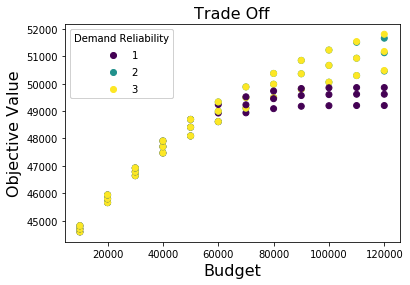

In [78]:
fig, ax = plot.subplots()

scatter = ax.scatter(budget, obj_value, 
                     #s=np.multiply(supplier_reliability,10),
                     c=demand_reliability)


# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Demand Reliability")

ax.add_artist(legend1)

plot.xlabel('Budget', fontsize=16)
plot.ylabel('Objective Value', fontsize=16)
plot.title('Trade Off'
           , fontsize=16)

# produce a legend with a cross section of sizes from the scatter
#handles, labels = scatter.legend_elements(prop="sizes", alpha=.6)
#legend2 = ax.legend(handles, labels, loc="lower right", title="Supplier Reliability")